# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [59]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np
from numpy import mean
import statistics

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

#defining colors for quick formatting 
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Loading Data

In [2]:
#load data files
raw = pd.read_csv("train.csv")
rawtest = pd.read_csv("test.csv")

In [3]:
#make a copy of the raw data to retain raw qualities 
train = raw.copy()
test = rawtest.copy()

## EDA

In [4]:
#viewing top 5 rows of train data 
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


**Observations**: 
- Confirmed there are 40 ciphered variables with coded names.
    - I will refer to variables as V1, V2, etc. 
    - I will not be able to apply real world scenarios or observations to this kind of data as I have no context to what the variable is.
    - Instead I will note positive/negative relationships and strength of correlation to target variable.
- Confirmed Target variable 0,1 as 41st column. 
    - 0 = no failure 
    - 1 = failure 

In [5]:
#confirming shape of train dataset 
train.shape

(20000, 41)

**Observations**: 
- the shape confirms 41 columns (40 of which are variables, 1 of which is the target)
- 20,000 rows in training data

In [6]:
#viewing top 5 rows of test data 
test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


**Observations:**
- rows in test set appear similar fromatting as train 
- 40 variables, ciphered 
- 1 target, 0,1 

In [7]:
#confirming shape of test dataset 
test.shape

(5000, 41)

**Observations**
- test data matches train data's 41 rows
- test data has 5,000 rows 

In [8]:
# let's check the data types of the columns in the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

Observations:
- All data points in the train dataset are float 65 or int64 and do not need to be adjusted
- There are 18 null values for var 1 and 2, will remove

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

Observations: 
- all variables in the test set are also float64 or int64 and do not need to be adjusted
- There are 5 and 6 null values for var 1 and 2, similar to train data.
    - I will impute remove

In [10]:
#checking for duplicates in both data sets 
train.duplicated().sum()

0

In [11]:
test.duplicated().sum()

0

- No duplicate values are in either dataset 

In [188]:
#Checking representation of target variable in train and test dataset 
train2['Target'].value_counts(normalize=True)

#Target variable with positive for failure is a minotiry of the dataset
#only 5.6% of observations

0   0.944
1   0.056
Name: Target, dtype: float64

In [14]:
test['Target'].value_counts(normalize=True)

#Target variable has same representation in Test dataset 
#again, minority of observations, will need to adjust for that 

0   0.944
1   0.056
Name: Target, dtype: float64

### Plotting histograms and boxplots for all the variables

In [15]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    ).set_title(feature)  # boxplot will be created and a star will indicate the mean value of the column w/ title
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
        

### Plotting all the features at one go

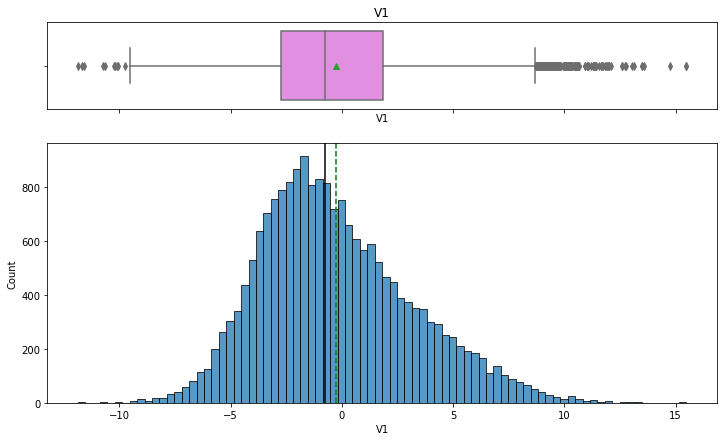

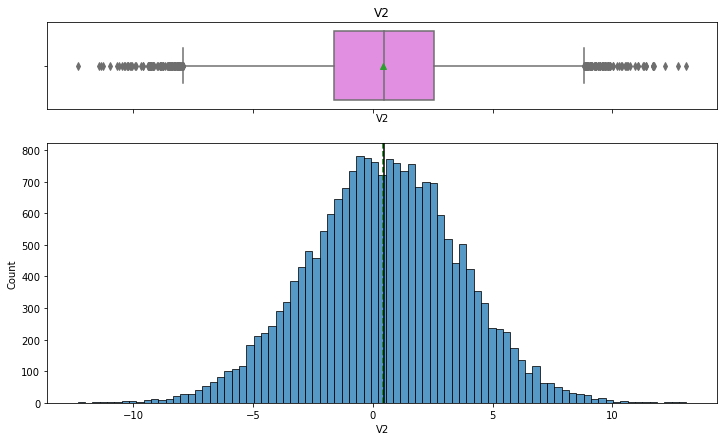

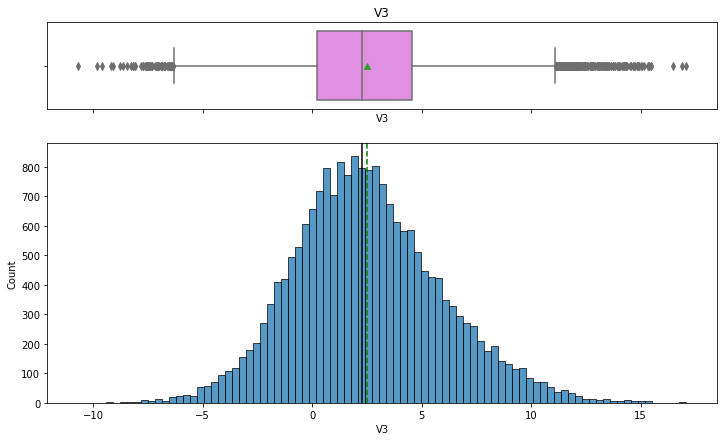

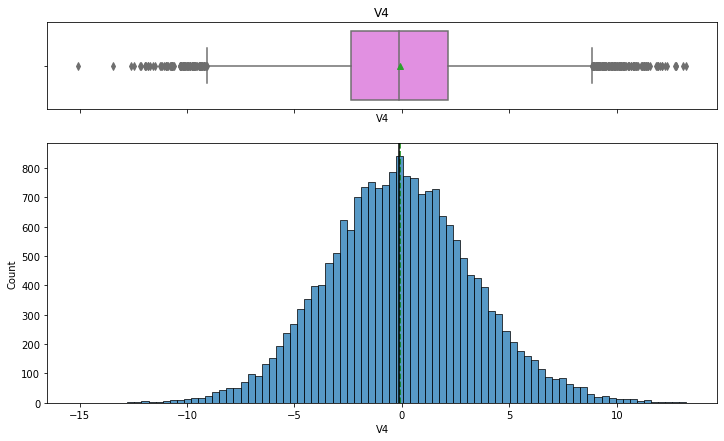

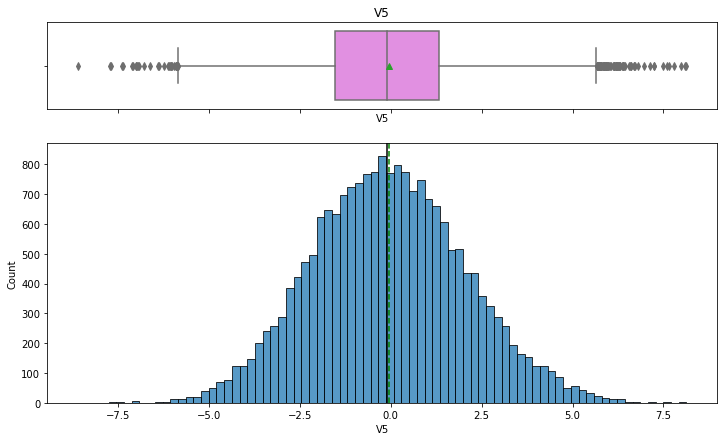

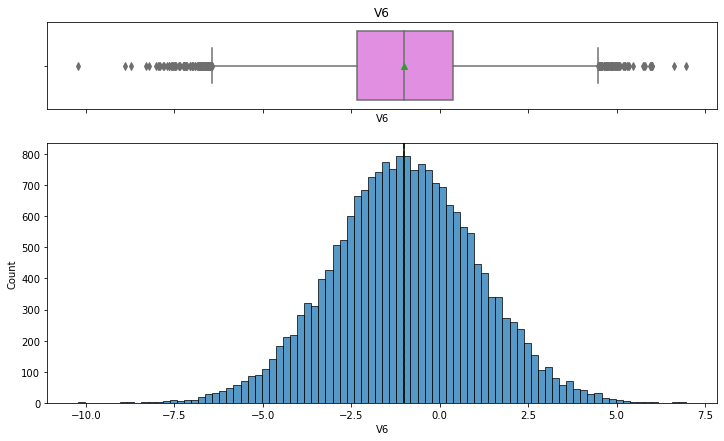

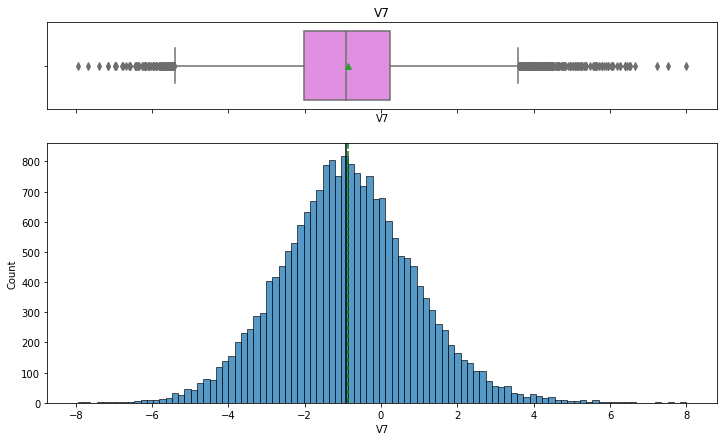

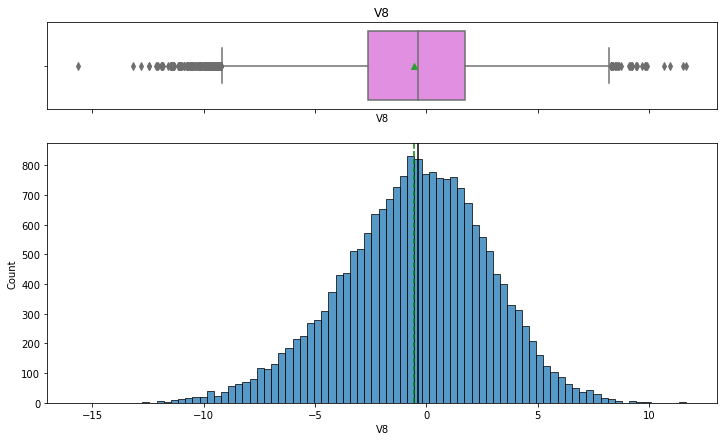

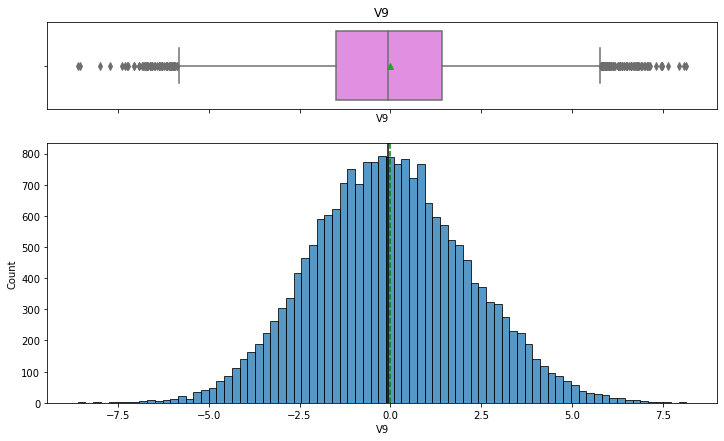

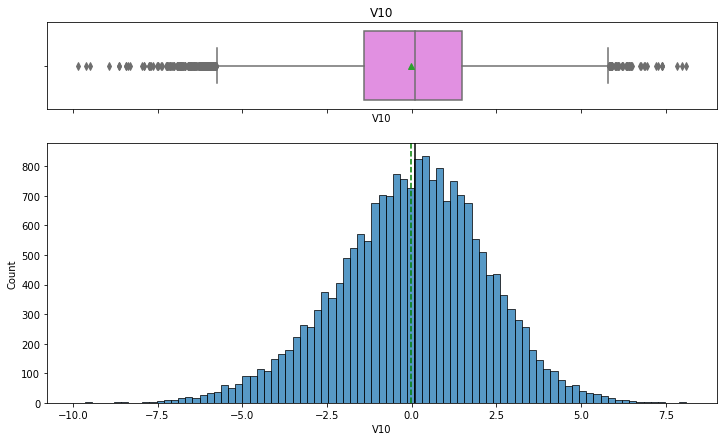

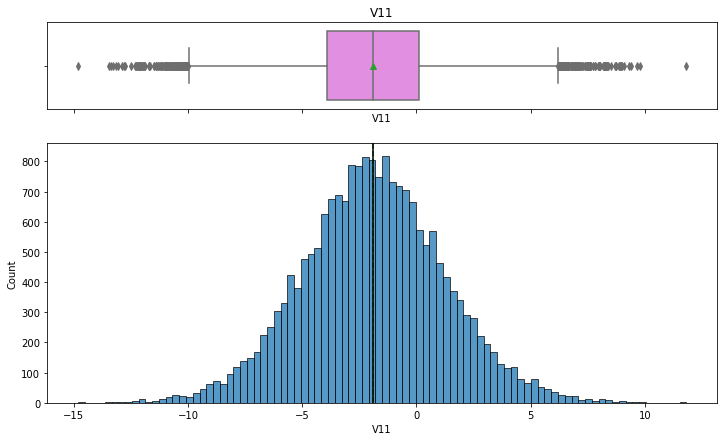

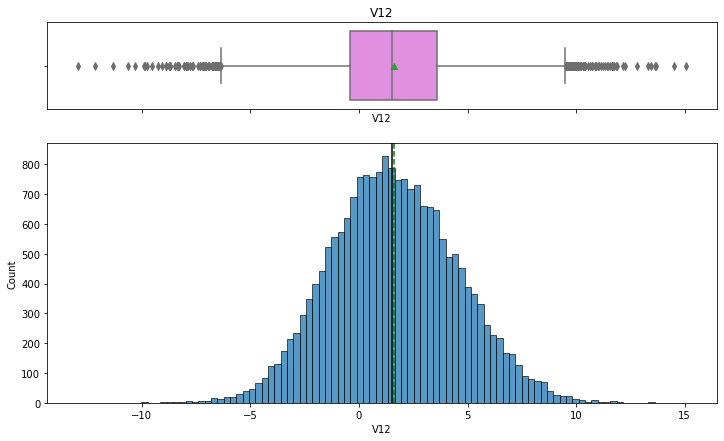

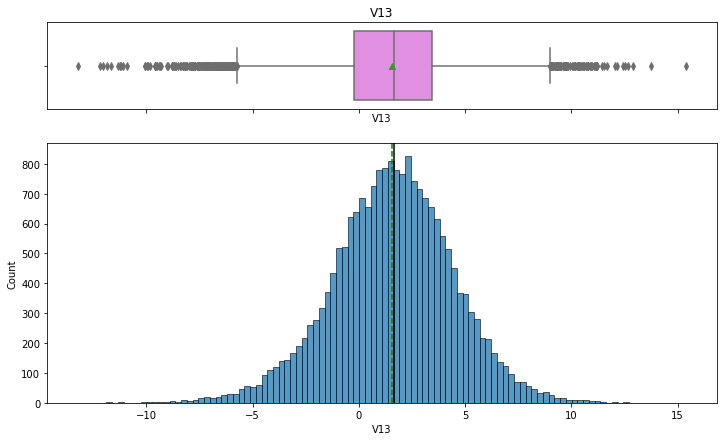

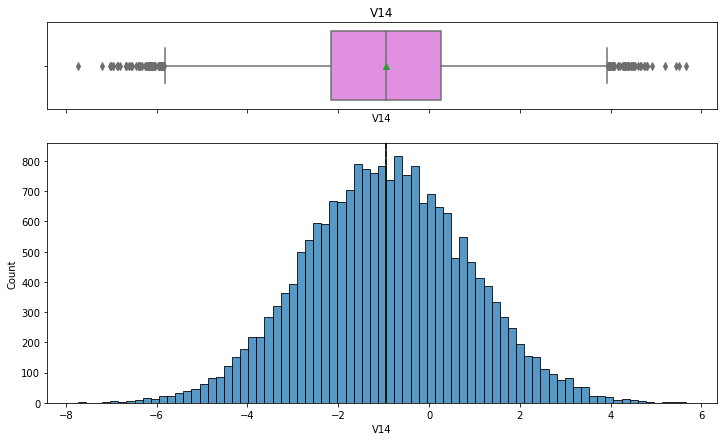

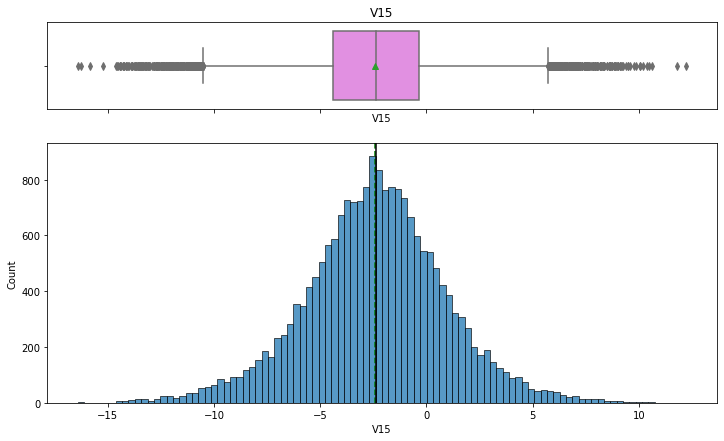

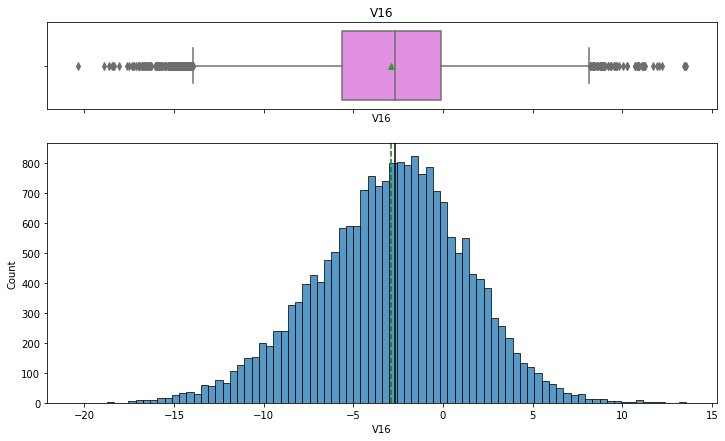

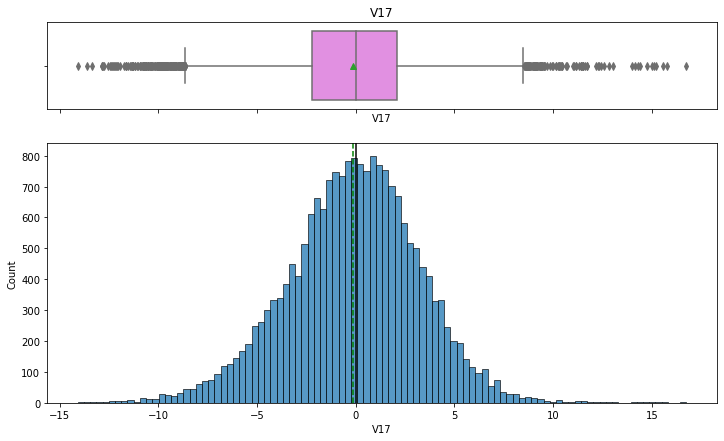

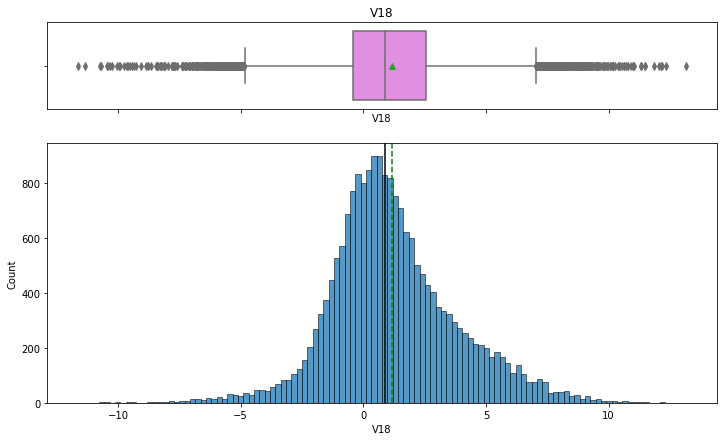

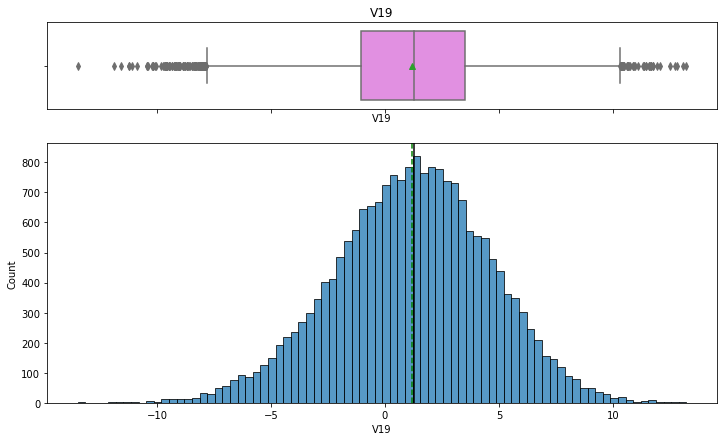

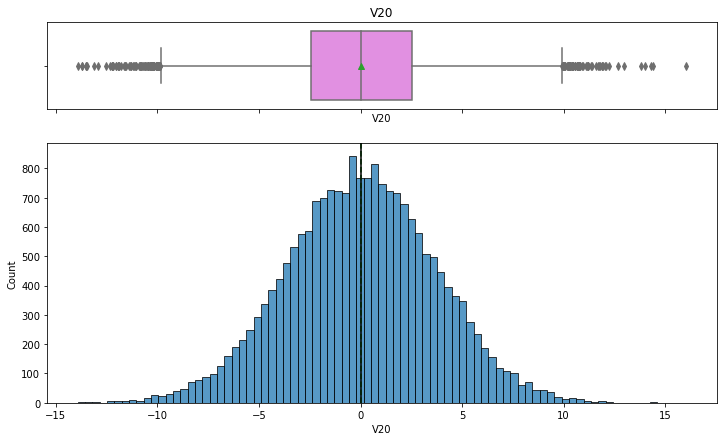

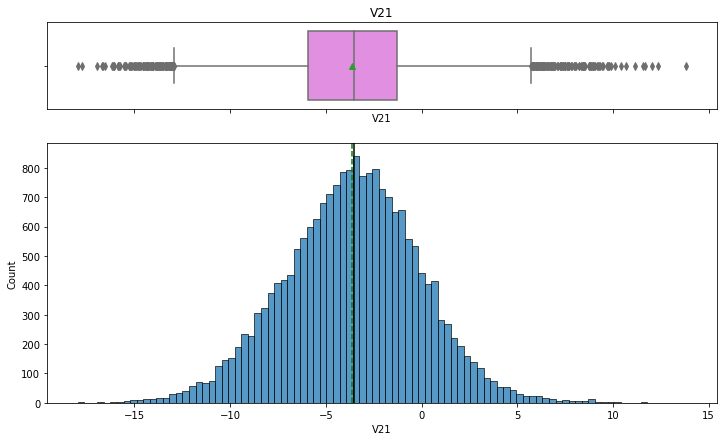

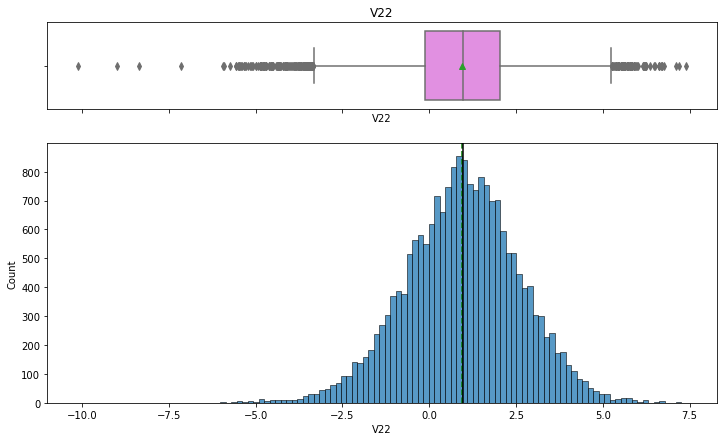

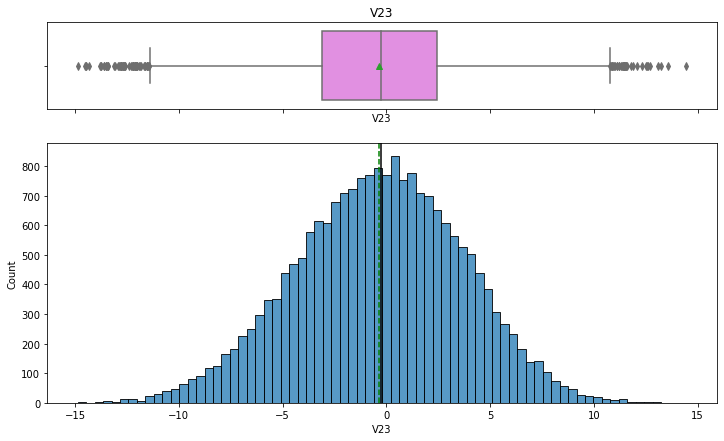

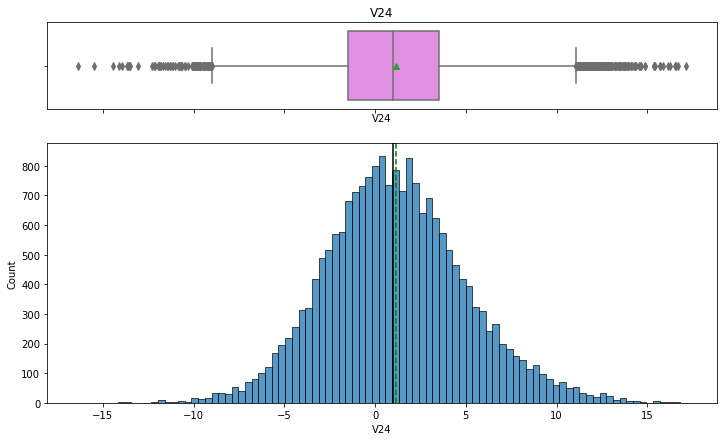

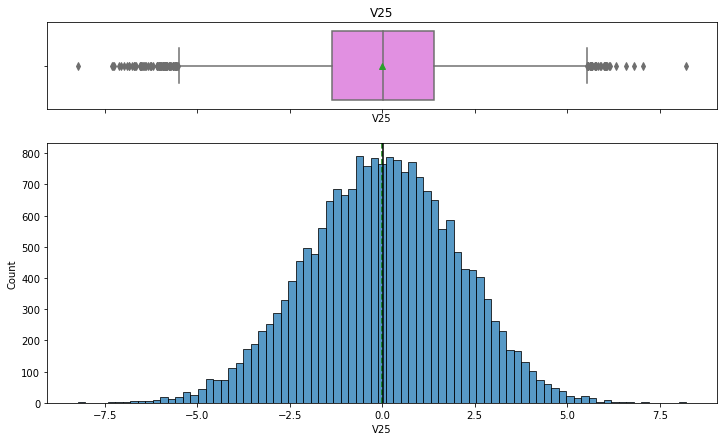

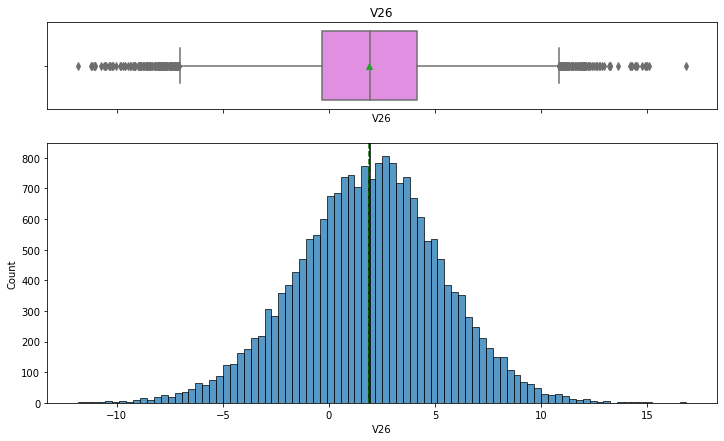

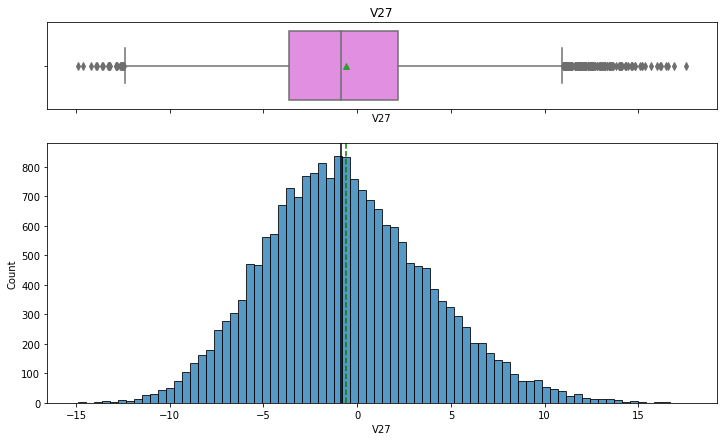

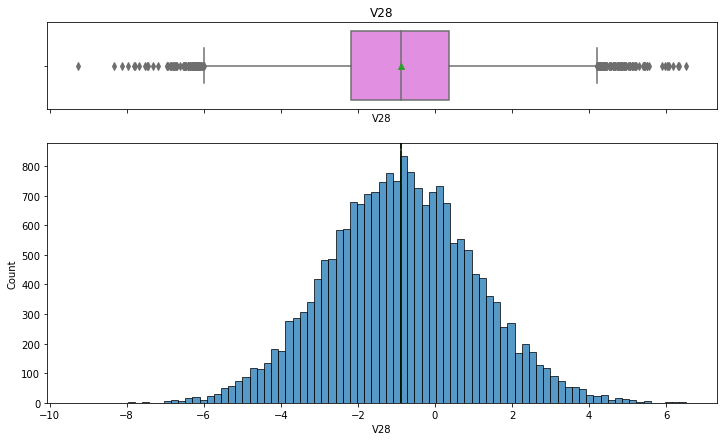

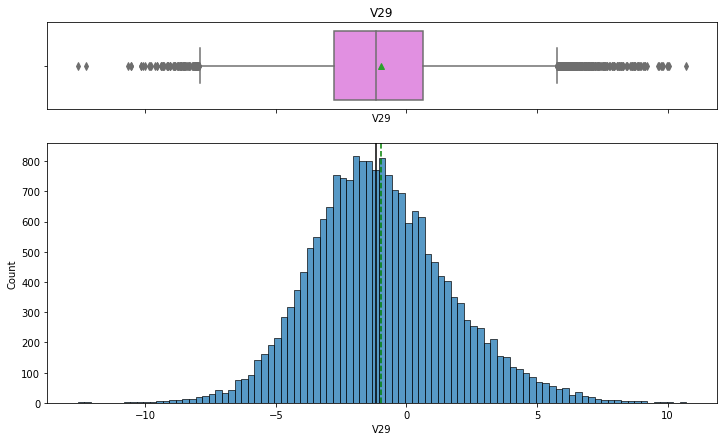

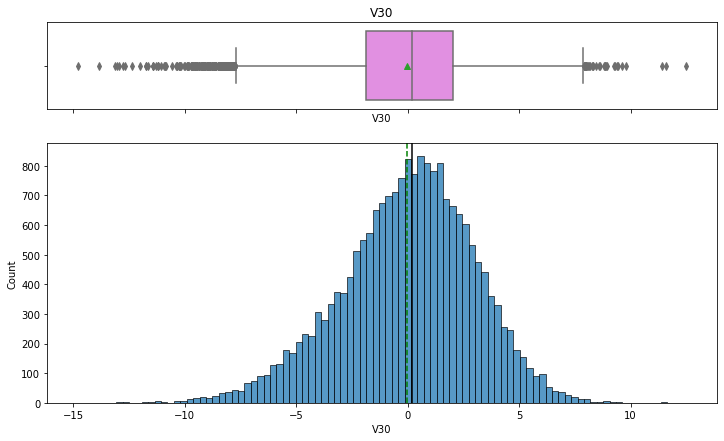

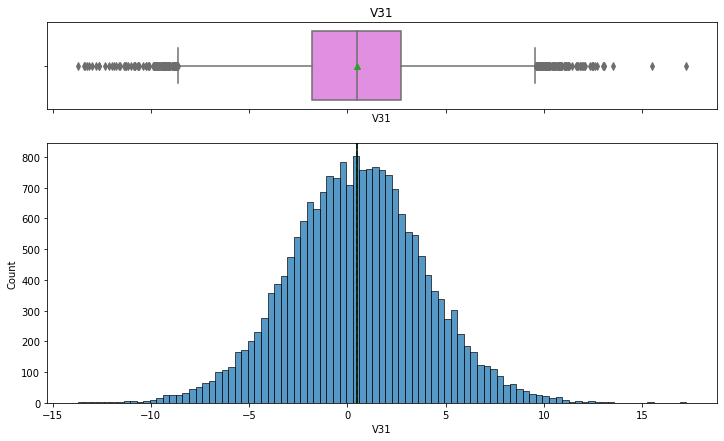

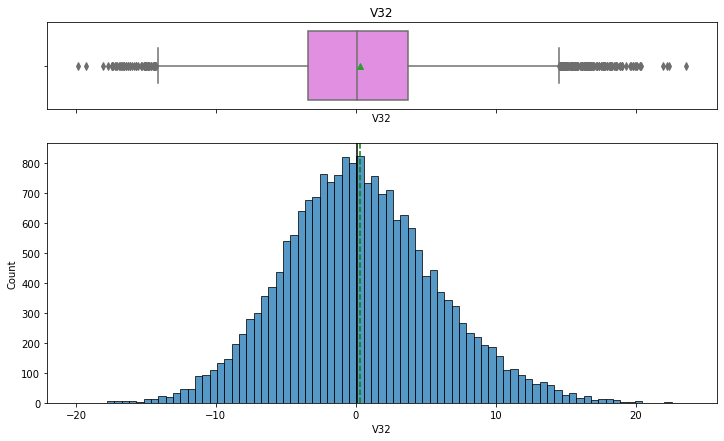

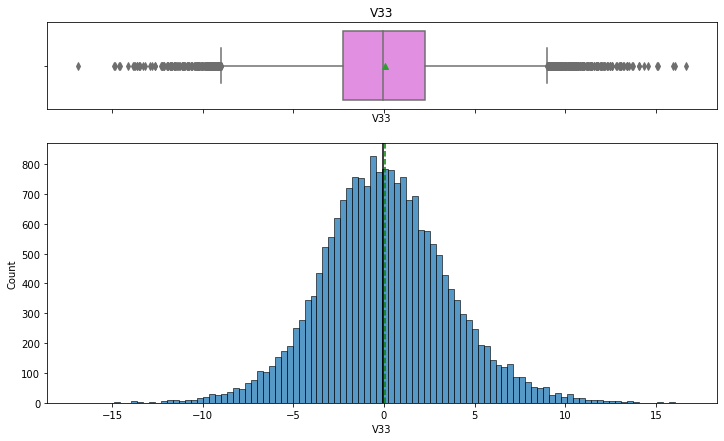

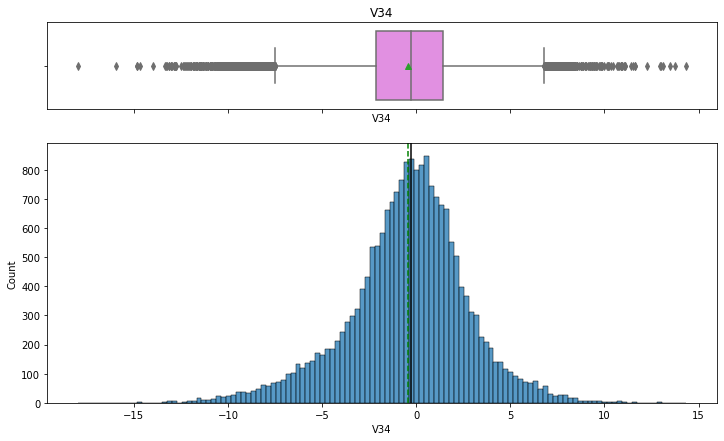

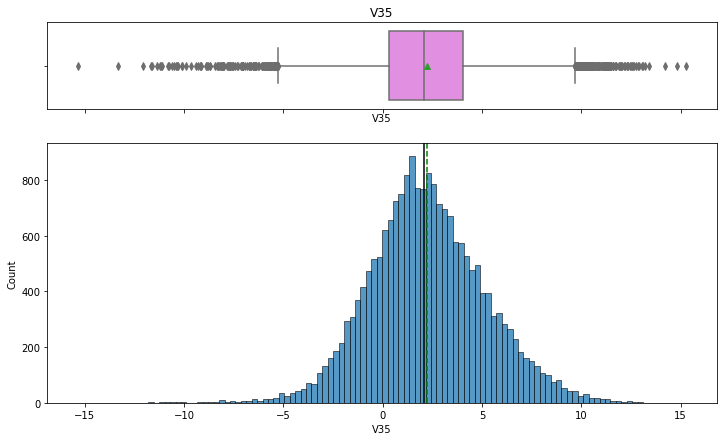

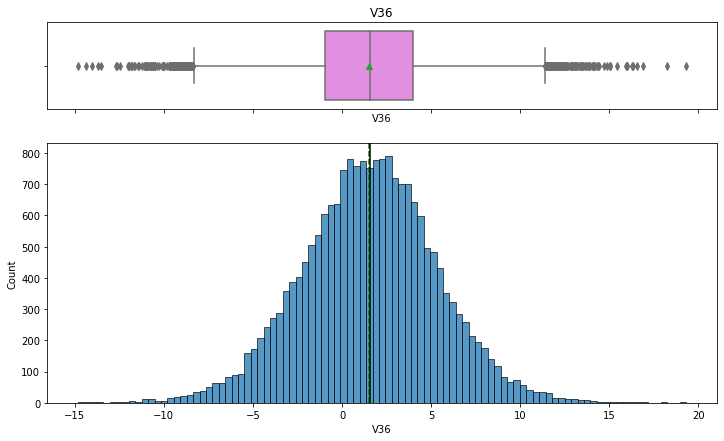

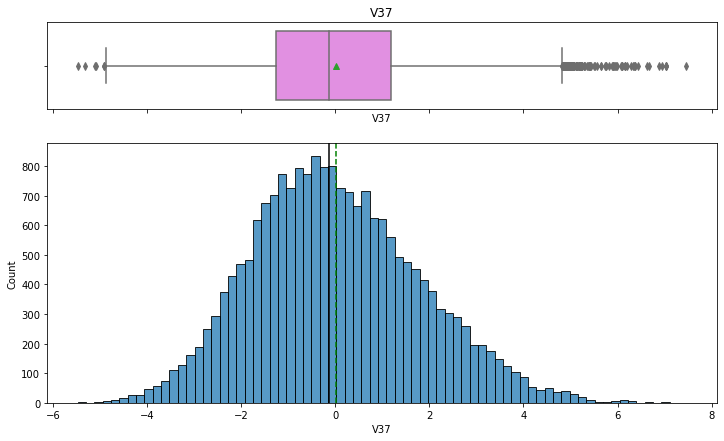

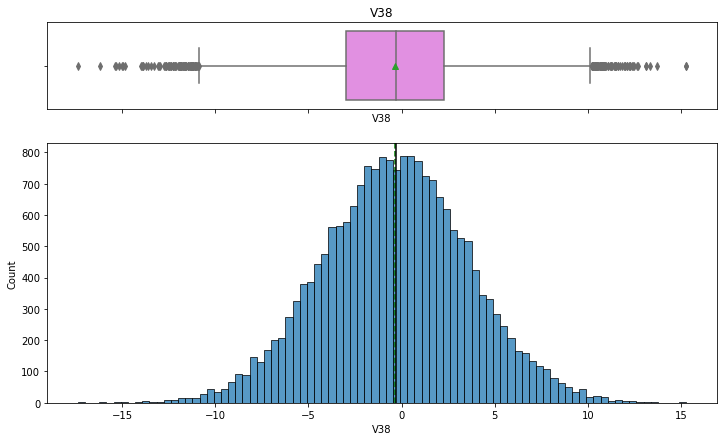

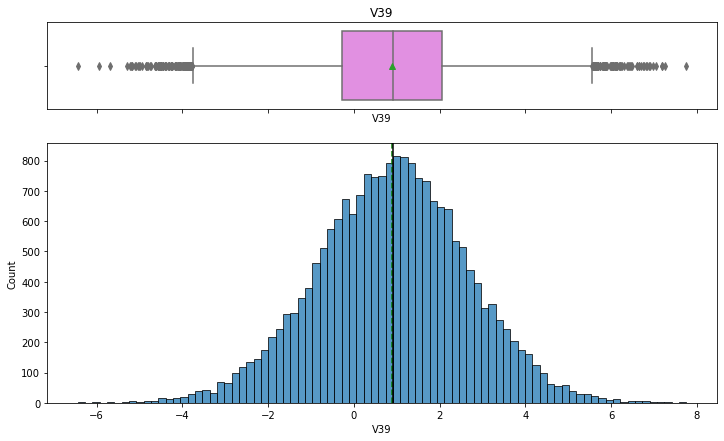

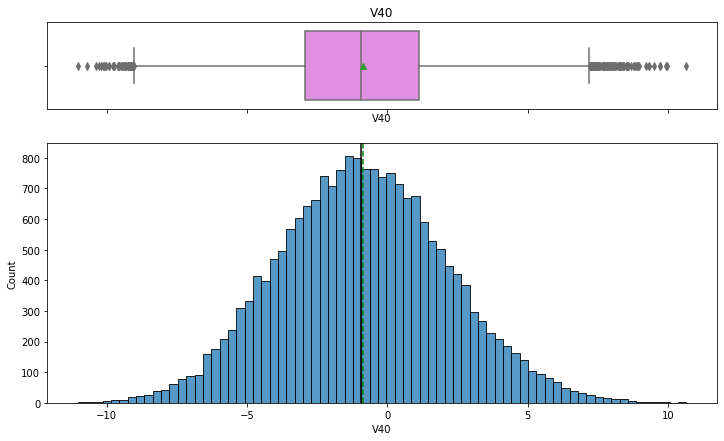

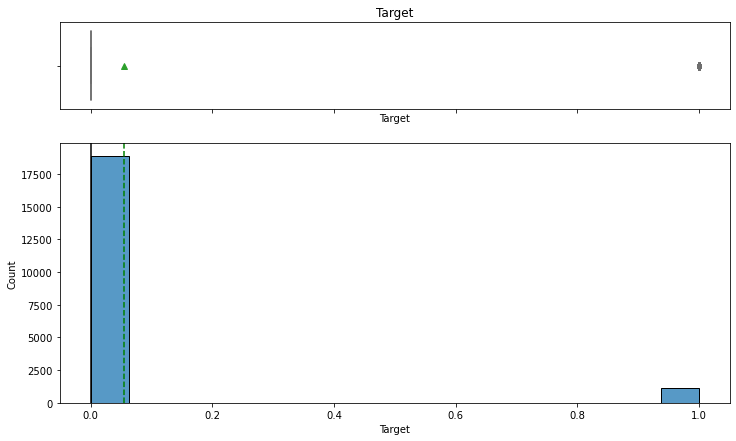

In [16]:
#plotting all features' histogram & boxplot
#NOTE: PROVIDING INDIVIDUAL FEATURE COMMENTARY AFTER FOLLOWING CELL 
#TO INCLUDE MEDIAN/MEAN IN EACH FEATURE'S REVIEW 
for feature in train.columns:
    histogram_boxplot(train, feature, figsize=(12, 7), kde=False, bins=None)    


In [17]:
#reviewing quartiles to see outliers 
train.describe()

#adding notes on range and quartiles to the observations markdown below 
#this will provide single reference paragraph per variable for future lookback 

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


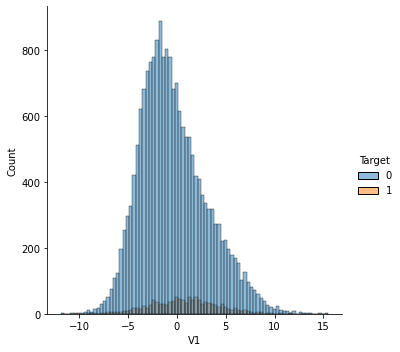

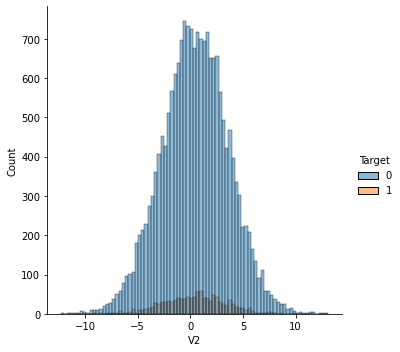

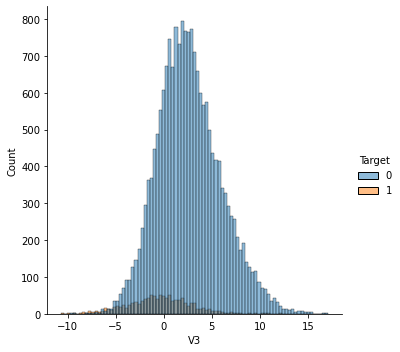

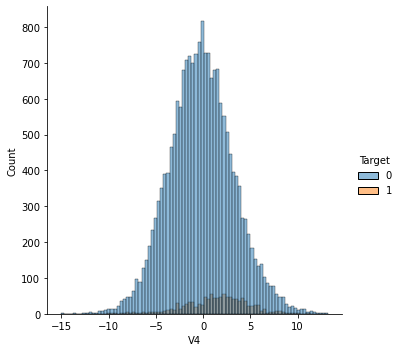

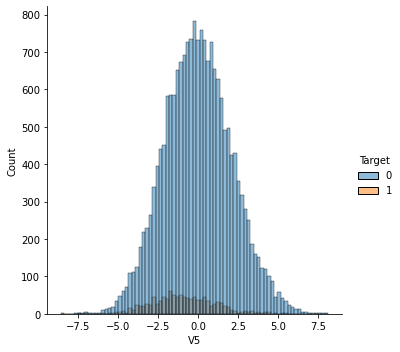

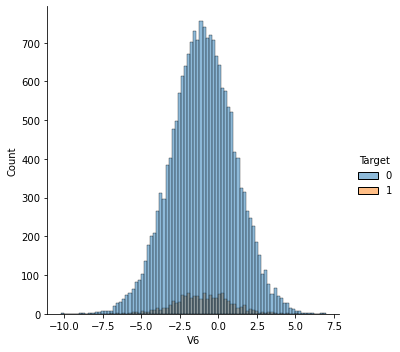

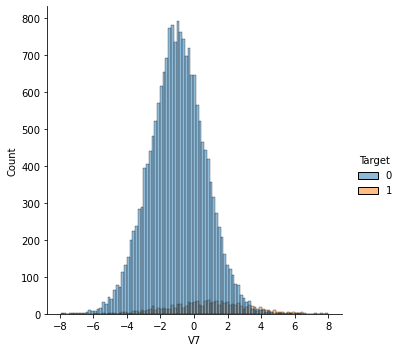

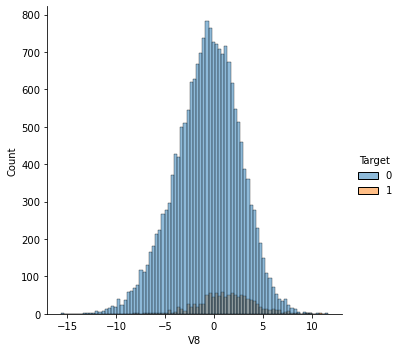

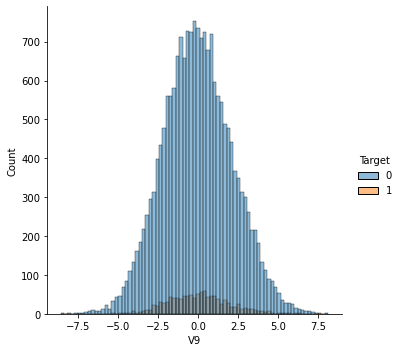

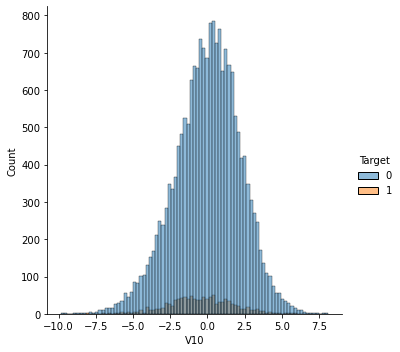

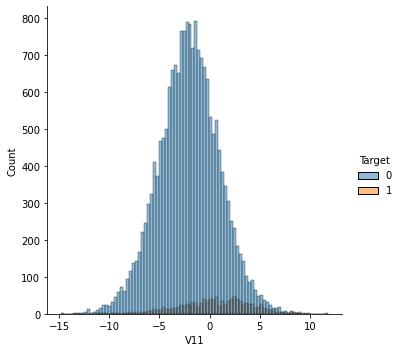

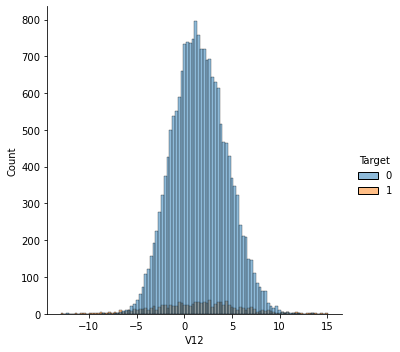

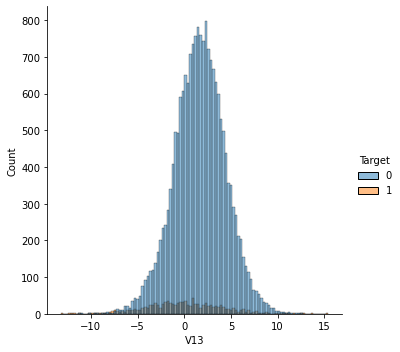

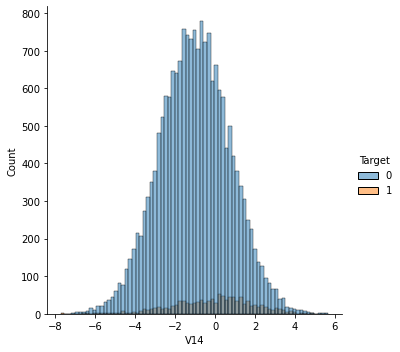

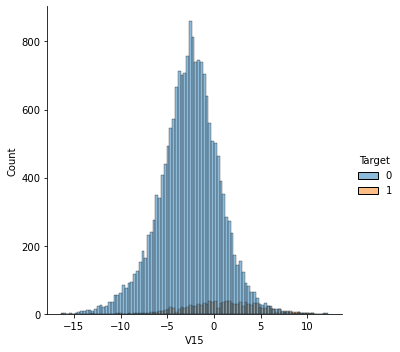

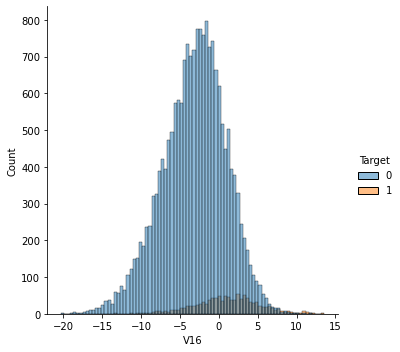

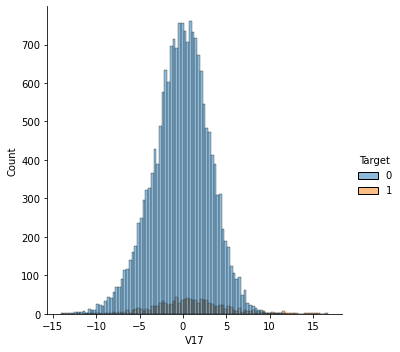

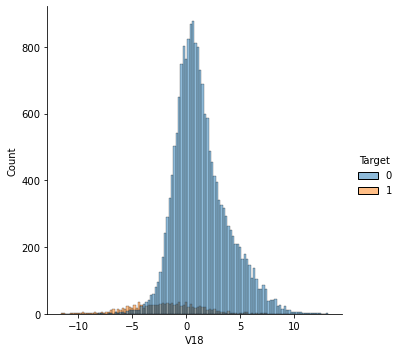

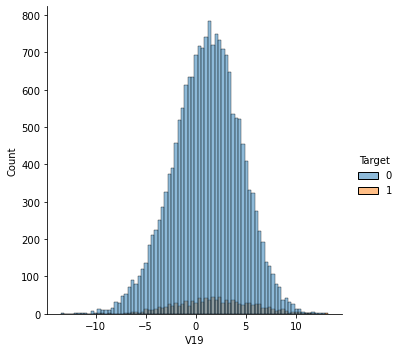

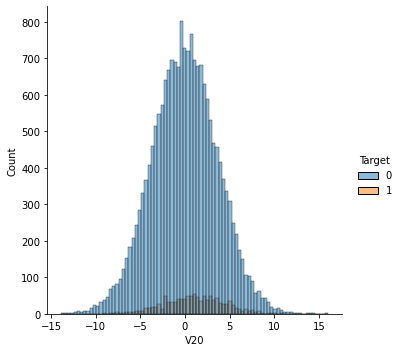

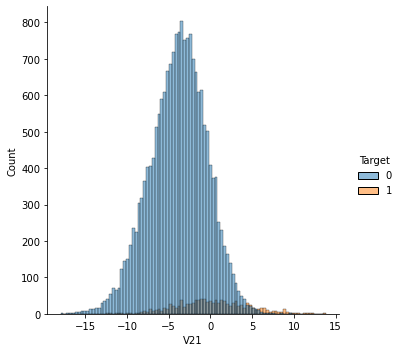

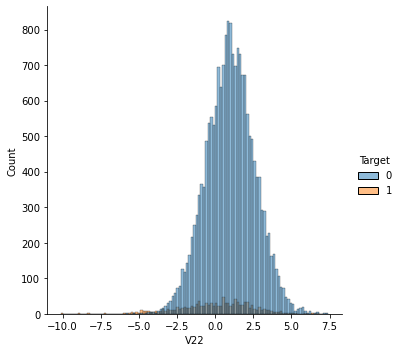

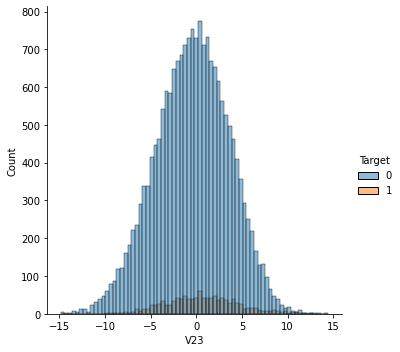

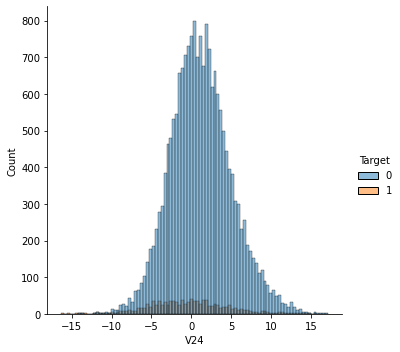

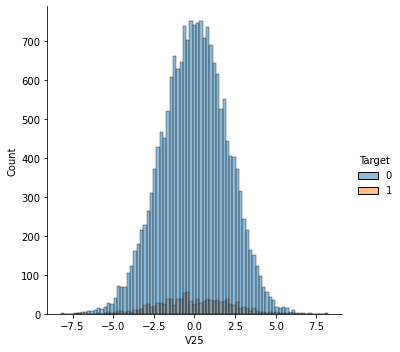

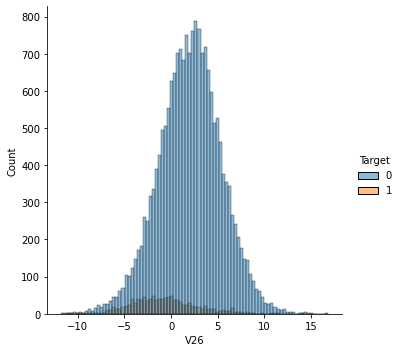

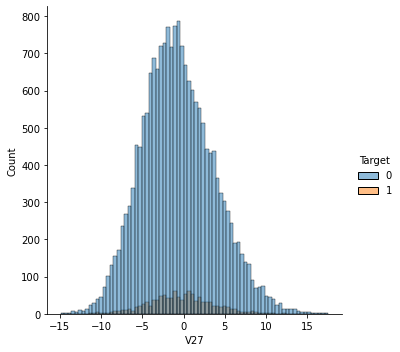

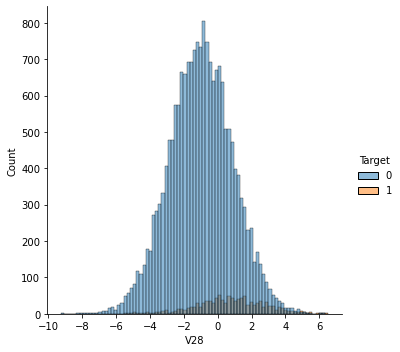

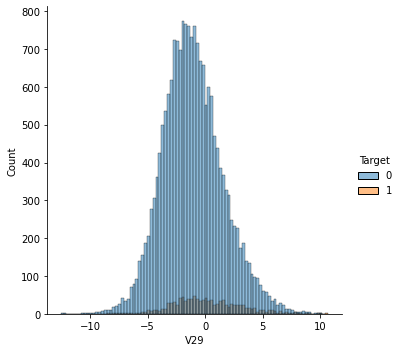

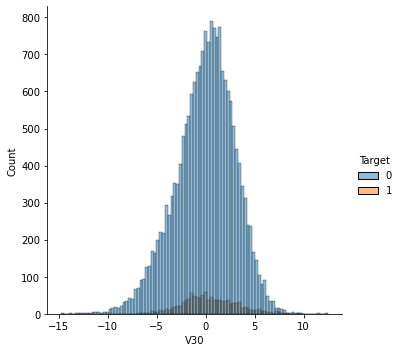

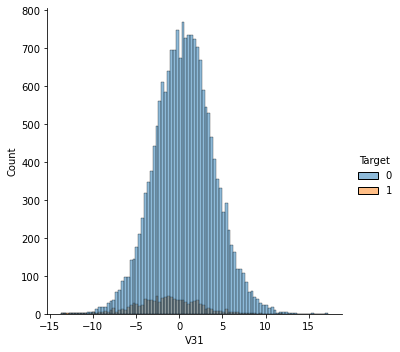

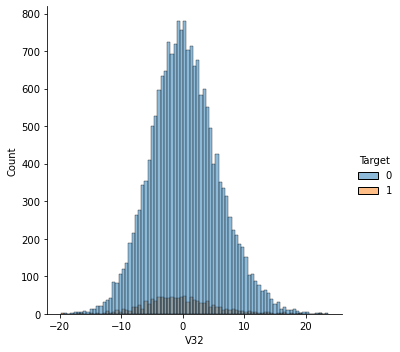

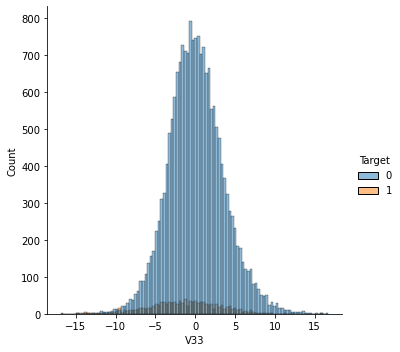

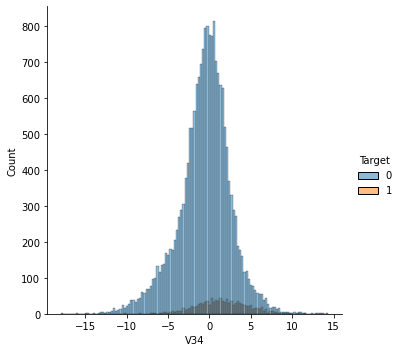

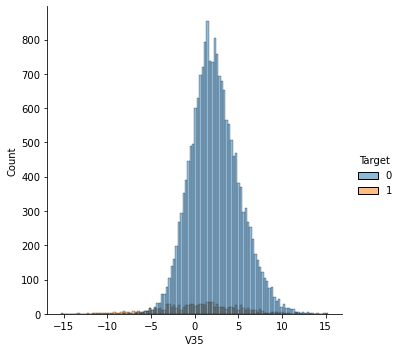

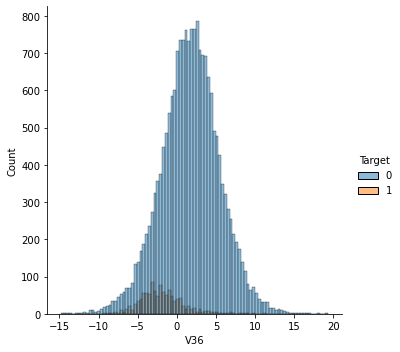

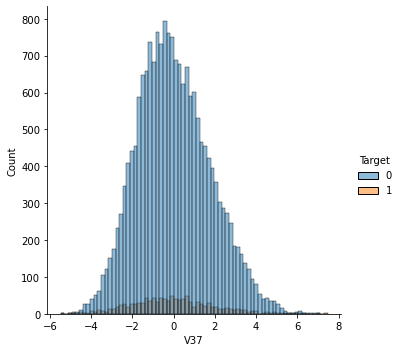

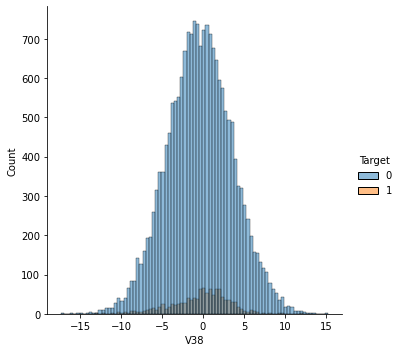

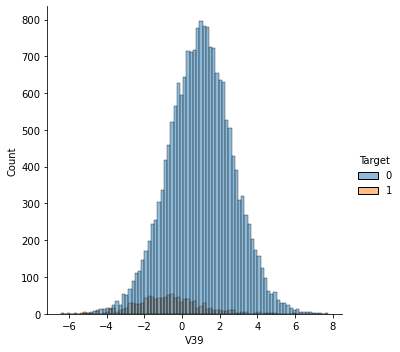

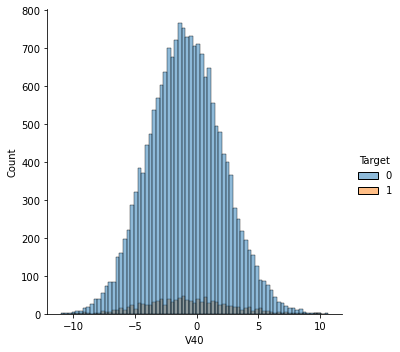

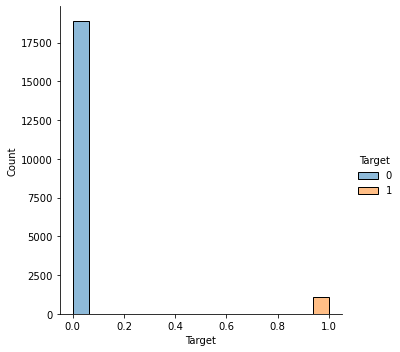

In [19]:
#Plotting displots with Target variable hue 

for feature in train.columns: 
        sns.displot(train,x=feature,hue='Target')

#distribution has lower peak at mean/median point
#this is  expected with lower observation counts on the positive target
#most variables have similar mean/median for target=1 with tighter ranges (fewer outliers)
#some variables show target with significantly shifted mean/median or ranges
#noting specifics in the Variable Observation Review markdown below

### Observations per Variable 
#### collected from histograms, displots, and describe functions above for single point of reference
NOTE: All data has been standardized when ciphered 

V1: 
- Distribution: Slightly left skewed, fairly normal
- Spread: moderately tight
- Min:  -11.876
- Mean:  -0.272
- Median:  1.677
- Max:  15.493
- Target notes: slightly higher median for failure, tighter distribution


V2: 
- Distribution: slight left skew, hard to see with longer tails 
- Spread: moderately tight 
- Range: bulk -8 to 8
- Min:  -12.32
- Mean:  0.44
- Median: 2.924
- Max:  13.089
- Target notes: slightly higher median for failure, tighter distribution

V3:
- Distribution: normal with tiny right skew 
- Spread: fairly tight, shifted positive
- Range: bulk -5 to 13 
- Min:  -10.708
- Mean:  2.485
- Median:  2.256
- Max:  17.091
- Target notes: significantly lower median for failure
	- failure distribution -10 to 8 vs -5 to 15 for nonfailure
	- values <-5 possible slight idicator of failure


V4: 
- Distribution: almost perfectly normal
- Spread: moderately tight 
- Range: +/- 10 with small tails 
- Min:  -15.082
- Mean:  -0.083
- Median:  -0.135
- Max:  13.236
- Target notes: slightly higher median for failure
	- failure distribution -5 to 8 vs -15 to 13 for nonfailure


V5: 
- Distribution: almost perfectly normal with no skew 
- Spread: tight
- Range: bulk of data between +/- 5, tails only out to +/- 8
- Min:  -8.603
- Mean:  -0.054
- Median:  -0.102
- Max:  8.134
- Target notes: slightly lower median for failure, 
 	- failure distribution -5 to 2.5 vs -7.5 to 7.5 for nonfailure


V6: 
- Distribution: almost perfectly normal, no skew 
- Spread: tighter, shifted slightly negative 
- Range: bulk between -7.5 and 5
- Min:  -10.227
- Mean:  -0.995
- Median:  -1.001
- Max:  6.976
- Target notes: target almost identical with tighter distribution


V7: 
- Distribution: almost perfectly normal
- Spread: tighter distribution, shifted slightly negative 
- Range: bulk of data between +/- 6
- Min:  -7.95
- Mean:  -0.879
- Median:  -0.917
- Max:  8.006
- Target notes: median fairly higher for failure (0 vs -2)
    - failure distribution much higher (-4 to 8 with long positive tail), non-failure is -8 to 4, much further negative 
    - values >4 possible *slight* indicator of failure 


V8: 
- Distribution: slightly left skewed 
- Spread: moderately tight, longer tail toward the negative 
- Range: bulk of dataa between -10 and 8, tails out to -15 and 12
- Min:  -15.658
- Mean:  -0.548
- Median:  -0.389
- Max:  11.679
- Target notes: median slightly higher (2 vs -3ish) for failure
    - failure distribution has bigger positive tail, nonfailure has further negative tail (-5 to 12 failure, -15 to 9 nonfailure) 
    - values <10 possible indicator of failure 

V9: 
- Distribution: almost perfectly distributed
- Spread: tighter distribution 	
- Range: data between +/- 7.5 
- Min:  -8.596
- Mean:  -0.017
- Median:  -0.068
- Max:  8.138
- Target notes: almost identical distribution 

V10: 
- Distribution: slight left skew
- Spread: moderately tight, shifted slightly negative 
- Range: data between -7.5 and 6
- Min:  -9.854
- Mean:  -0.013
- Median:  0.101
- Max:  8.108
- Target notes: almost identical, slightly lower median 

V11: 
- Distribution: normal, shifted negative 
- Spread: very tight 
- Range: -10 to 7, tails -15 to 12 
- Min:  -14.832
- Mean:  -1.895
- Median:  -1.921
- Max:  11.826
- Target notes: median much hgher for failure (1 vs -3) 
    - failure has more positive distribution -10 to 13 
    - nonfailure has longer negative tail -15 to 10 
    - values <10 possible indicator of failure 

V12: 
- Distribution: slight right skew, shifted positive
- Spread: moderately tight 
- Range: -5 to 10, tails from -12 to 15 
- Min:  -12.948
- Mean:  1.605
- Median:  1.508
- Max:  15.081
- Target notes: failure has much longer tails
    - -13 to 15 failure vs -7 to 11 nonfailure 
    - values <-17 or >12 possible indicator of failure 

V13: 
- Distribution: slight left skew, but shifted positive
- Spread: moderately tight 
- Range: -10 to 10, tails from -12 to 12 
- Min:  -13.228
- Mean:  1.58
- Median:  1.637
- Max:  15.42
- Target notes: failure has distribution shifted slightly negative
    - failure -13 to 10 vs -8 to 12 nonfailure 
    - values <-9 possible indicator of failure 

V14: 
- Distribution: normal
- Spread: very tight
- Range: -6 to 4, tails -8 to 6
- Min:  -7.739
- Mean:  -0.951
- Median:  -0.957
- Max:  5.671
- Target notes: Failure distribution shifted more positive
    - failure -4 to 5 vs -8 to 6 nonfailure 

V15: 
- Distribution: normal
- Spread: moderately tight
- Range: -13 to 8, tails -16 to 11 
- Min:  -16.417
- Mean:  -2.415
- Median:  -2.383
- Max:  12.246
- Target notes: failure distribution shifted positive with longer positive tail
    - failure -8 to 13 vs nonvailure -15 to 7 with a couple high outliers 

V16: 
- Distribution: slightly left skewed
- Spread: further spread
- Range: -15 to 12, tails -20 to 14
- Min:  -20.374
- Mean:  -2.925
- Median:  -2.683
- Max:  13.583
- Target notes: Failure distribution shifted positive + longer positive tail
    - failure -10 to 14 vs nonfailure -20 to 10 
    - values >5 possible moderate indicator of failure 


V17: 
- Distribution: slightly left skewed
- Spread: moderately tight
- Range: bulk between -8 and 8 
- Min:  -14.091
- Mean:  -0.134
- Median:  -0.015
- Max:  16.756
- Target notes: similar distribution, failure *slightly* shifted positive 

V18: 
- Distribution: slightly right skewed
- Spread: tighter, high center 
- Range: bulk -5 to 8
- - Min:  -11.644
- Mean:  1.189
- Median:  0.883
- Max:  13.18
- Target notes: Both have right skewed shape, but failure shifted negative with long neg tail
    - failure -13 to 5 vs nonfailure -5 to 13 
    - more negative score could be indicator of failure 
    - values <-5 possible moderate indicator of failure 

V19:  
- Distribution: normal, shifted slightly positive
- Spread: moderately tight
- Range: bulk -8 to 10
- Min:  -13.492
- Mean:  1.182
- Median:  1.279
- Max:  13.238
- Target notes: very similar distribution 

V20:  
- Distribution: normal distribution
- Spread: moderately tight
- Range: -10 to 10, balanced
- Min:  -13.923
- Mean:  0.024
- Median:  0.033
- Max:  16.052
- Target notes: very similar distribution
    - failure shifted slightly positive, but not significantly

V21:  
- Distribution: slightly left skewed
- Spread: moderately tight, shifted slightly negative
- Range: bulk -12 to 8 with tails 
- Min:  -17.956
- Mean:  -3.611
- Median:  -3.533
- Max:  13.84
- Target notes: failure shifted much further positive with longer positive tail
    - failure -8 to 15 vs nonfailiure -18 to 5 
    - values >5 possible indicator of failure 

V22:  
- Distribution: normal, shifted positive, some far negative outliers 
- Spread: fairly tight 
- Range: bulk -3 to 6
- Min:  -10.122
- Mean:  0.952
- Median:  0.975
- Max:  7.41
- Target notes: similar distribution, slightly shifted negative with longer negative tail 
    - failure -9 to 4, nonfailure -4 to 7
    - lower values <-4 might be indicator of possible failure 

V23:  
- Distribution: slightly left skewed
- Spread: moderately tight 
- Range: bulk -10 to 10, similar tails 
- Min:  -14.866
- Mean:  -0.366
- Median:  -0.262
- Max:  14.459
- Target notes: almost identical distribution, slightly higher tail
    - failure ranges from -8 to 15, nonfailure has significant bulk down to -15 with lower tail up to 15
    -  values >5 may be *slight* indicator of failure, but not strong

V24:  
- Distribution: slightly right skewed 
- Spread: moderately tight, longer positive tail 
- Range: bulk -10 to 15 
- Min:  -16.387
- Mean:  1.134
- Median:  0.969
- Max:  17.163
- Target notes: more lower tail for failure than non
  failure -15 to about 10, nonfailure has some outliers to -15 but leans more positive up to 17
    - lower values <-10 may be weak indicator of possible failure 

V25:  
- Distribution: normal
- Spread: tight! 
- Range: -5 to 5 plus balanced tails 
- Min:  -8.228
- Mean:  -0.002
- Median:  0.025
- Max:  8.223
- Target notes: very similar distribution 

V26:  
- Distribution: normal, slightly longer positive tail 
- Spread: moderately tight 
- Range:  bulk -8 to 11 
- Min:  -11.834
- Mean:  1.874
- Median:  1.951
- Max:  16.836
- Target notes: failure distribution shifted lower
	- Meidan closer to -2 for failure, vs 3 for non-failure 

V27:  
- Distribution: slight right skew 
- Spread: moderately tight 
- Range: -10 to 12 plus tails with a bulkier positive tail 
- Min:  -14.905
- Mean:  -0.612
- Median:  -0.885
- Max:  17.56
- Target notes: similar distribution

V28:  
- Distribution: almost normal, shifted slightly negative 
- Spread: tighter 
- Range: -5 to 4, longer negative tail 
- Min:  -9.269
- Mean:  -0.883
- Median:  -0.891
- Max:  6.528
- Target notes: failure distribution shifted higher 
	- Failure range -4 to 6+, nonfailure down to -10 up to 6
	- Values >4 possible *slight* indicator of failure 

V29:  
- Distribution: slightly right skewed 
- Spread: a little tigheter 
- Range: -8 to 8, negative outliers are more extreme but there are a higher count of positive outliers
- Min:  -12.579
- Mean:  -0.986
- Median:  -1.176
- Max:  10.722 
- Target notes: similar distribution 

V30:  
- Distribution: slight left skew
- Spread: moderately tight 
- Range: -10 to 8 plus tails with left skew 
- Min:  -14.796
- Mean:  -0.016
- Median:  0.184
- Max:  12.506
- Target notes: similar distribution

V31:  
- Distribution: normal
- Spread: tight 
- Range: +/- 7 with similar tails 
- Min:  -13.723
- Mean:  0.487
- Median:  0.49
- Max:  17.255
- Target notes: failure sitribution shifted to negative 
	- Failure median closer to -3, non-failure about 1 
	- values <-10 possible *slight* indicator of failure 

V32:  
- Distribution: slight right skew 
- Spread: moderately tight 
- Range: bulk +/-10, bulkier tail to the positive above 20 
- Min:  -19.877
- Mean:  0.304
- Median:  0.052
- Max:  23.633
- Target notes: similar distribution 

V33:  
- Distribution: slight right skew 
- Spread: slightly tighter
- Range: almost all data points between +/-10, tails +/-15
- Min:  -16.898
- Mean:  0.05
- Median:  -0.066
- Max:  16.692 
- Target notes: similar distribution 

V34:  
- Distribution: slight left skew 
- Spread: slightly tighter, similar to v33
- Range: almost all data points between +/-10, tails +/-15 
- Min:  -17.985
- Mean:  -0.463
- Median:  -0.255
- Max:  14.358
- Target notes: failure distribution shifted slightly positive 
	- failure median 1, nonfailure 0
	- both groups have tails between 8 and 15

V35:  
- Distribution: slight right skew, shifted positive
- Spread: tight 
- Range: -5 to 10, tails -12 to 12 
- Min:  -15.35
- Mean:  2.23
- Median:  2.099
- Max:  15.291
- Target notes: Failure distribution shifted negative 
	- failure -15 to 12, nonfailure some lower tails to -15 but up to 15 
	- values <-5 possible moderate indicator of failure 

V36:  
- Distribution: normal, shifted slightly positive  
- Spread: not as tight, wider tails 
- Range: -10 to 15, tails -15 to 20
- Min:  -14.833
- Mean:  1.515
- Median:  1.567
- Max:  19.33
- Target notes: failure distribution shifted negative 
	- failure median -3, nonfailure about 2 
	- nonfailure overlaps failure significantly, no outstanding tails for failure 

V37:  
- Distribution: slight right skew  
- Spread: very tight 
- Range: -4 to 6, tails -6 to 8 
- Min:  -5.478
- Mean:  0.011
- Median:  -0.128
- Max:  7.467
- Target notes: similar distribution 

V38:  
- Distribution: normal 
- Spread: Moderately tight 
- Range: +/-10, tails to +/-18
- Min:  -17.375
- Mean:  -0.344
- Median:  -0.317
- Max:  15.29
- Target notes: similar distribution 

V39:  
- Distribution: normal
- Spread: very tight 
- Range: -4 to 6, tails -7 to 8
- Min:  -6.439
- Mean:  0.891
- Median:  0.919
- Max:  7.76
- Target notes: failure distribution shifted negative with longer neg tail
	- failure median -1, nonfailure 1-2 
	- Values <-3 possible indicator of failure 


V40:  
- Distribution: slight right skew 
- Spread: moderately tight 
- Range: +/-10, Outliers clustered close to top/bottom whiskers 
- Min:  -11.024
- Mean:  -0.876
- Median:  -0.921
- Max:  10.654
- Target notes: similar distribution 

In [22]:
#dropping NA values 
train2=train.dropna()
test2=test.dropna()

In [23]:
#confirming that the total dataset has been reduced to 19964 rows 
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19964 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19964 non-null  float64
 1   V2      19964 non-null  float64
 2   V3      19964 non-null  float64
 3   V4      19964 non-null  float64
 4   V5      19964 non-null  float64
 5   V6      19964 non-null  float64
 6   V7      19964 non-null  float64
 7   V8      19964 non-null  float64
 8   V9      19964 non-null  float64
 9   V10     19964 non-null  float64
 10  V11     19964 non-null  float64
 11  V12     19964 non-null  float64
 12  V13     19964 non-null  float64
 13  V14     19964 non-null  float64
 14  V15     19964 non-null  float64
 15  V16     19964 non-null  float64
 16  V17     19964 non-null  float64
 17  V18     19964 non-null  float64
 18  V19     19964 non-null  float64
 19  V20     19964 non-null  float64
 20  V21     19964 non-null  float64
 21  V22     19964 non-null  float64
 22

In [24]:
#confirming the same for test 
test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4989 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4989 non-null   float64
 1   V2      4989 non-null   float64
 2   V3      4989 non-null   float64
 3   V4      4989 non-null   float64
 4   V5      4989 non-null   float64
 5   V6      4989 non-null   float64
 6   V7      4989 non-null   float64
 7   V8      4989 non-null   float64
 8   V9      4989 non-null   float64
 9   V10     4989 non-null   float64
 10  V11     4989 non-null   float64
 11  V12     4989 non-null   float64
 12  V13     4989 non-null   float64
 13  V14     4989 non-null   float64
 14  V15     4989 non-null   float64
 15  V16     4989 non-null   float64
 16  V17     4989 non-null   float64
 17  V18     4989 non-null   float64
 18  V19     4989 non-null   float64
 19  V20     4989 non-null   float64
 20  V21     4989 non-null   float64
 21  V22     4989 non-null   float64
 22  

In [25]:
#finding how many rows for each variable are outside of 4 times the interquartile range 
#observations noted below the results

for feature in train2.columns:
        print("Total rows greater than 4*IQR for ",
              feature,": ",
              len(train2[ (abs(train2[feature])>=
                           (4*((np.quantile(train2[feature], 0.75))-
                            (np.quantile(train2[feature], 0.25))))) ]))

Total rows greater than 4*IQR for  V1 :  0
Total rows greater than 4*IQR for  V2 :  0
Total rows greater than 4*IQR for  V3 :  0
Total rows greater than 4*IQR for  V4 :  0
Total rows greater than 4*IQR for  V5 :  0
Total rows greater than 4*IQR for  V6 :  0
Total rows greater than 4*IQR for  V7 :  0
Total rows greater than 4*IQR for  V8 :  0
Total rows greater than 4*IQR for  V9 :  0
Total rows greater than 4*IQR for  V10 :  0
Total rows greater than 4*IQR for  V11 :  0
Total rows greater than 4*IQR for  V12 :  0
Total rows greater than 4*IQR for  V13 :  1
Total rows greater than 4*IQR for  V14 :  0
Total rows greater than 4*IQR for  V15 :  2
Total rows greater than 4*IQR for  V16 :  0
Total rows greater than 4*IQR for  V17 :  0
Total rows greater than 4*IQR for  V18 :  5
Total rows greater than 4*IQR for  V19 :  0
Total rows greater than 4*IQR for  V20 :  0
Total rows greater than 4*IQR for  V21 :  0
Total rows greater than 4*IQR for  V22 :  2
Total rows greater than 4*IQR for  V23 : 

**Outlier Observation:**

- almost no variables have lines outside the 4 X IQR range 
    - V13, V15, V18, V22, V34, V35 do 
    - Will trim the whiskers to match 4XIQR value 

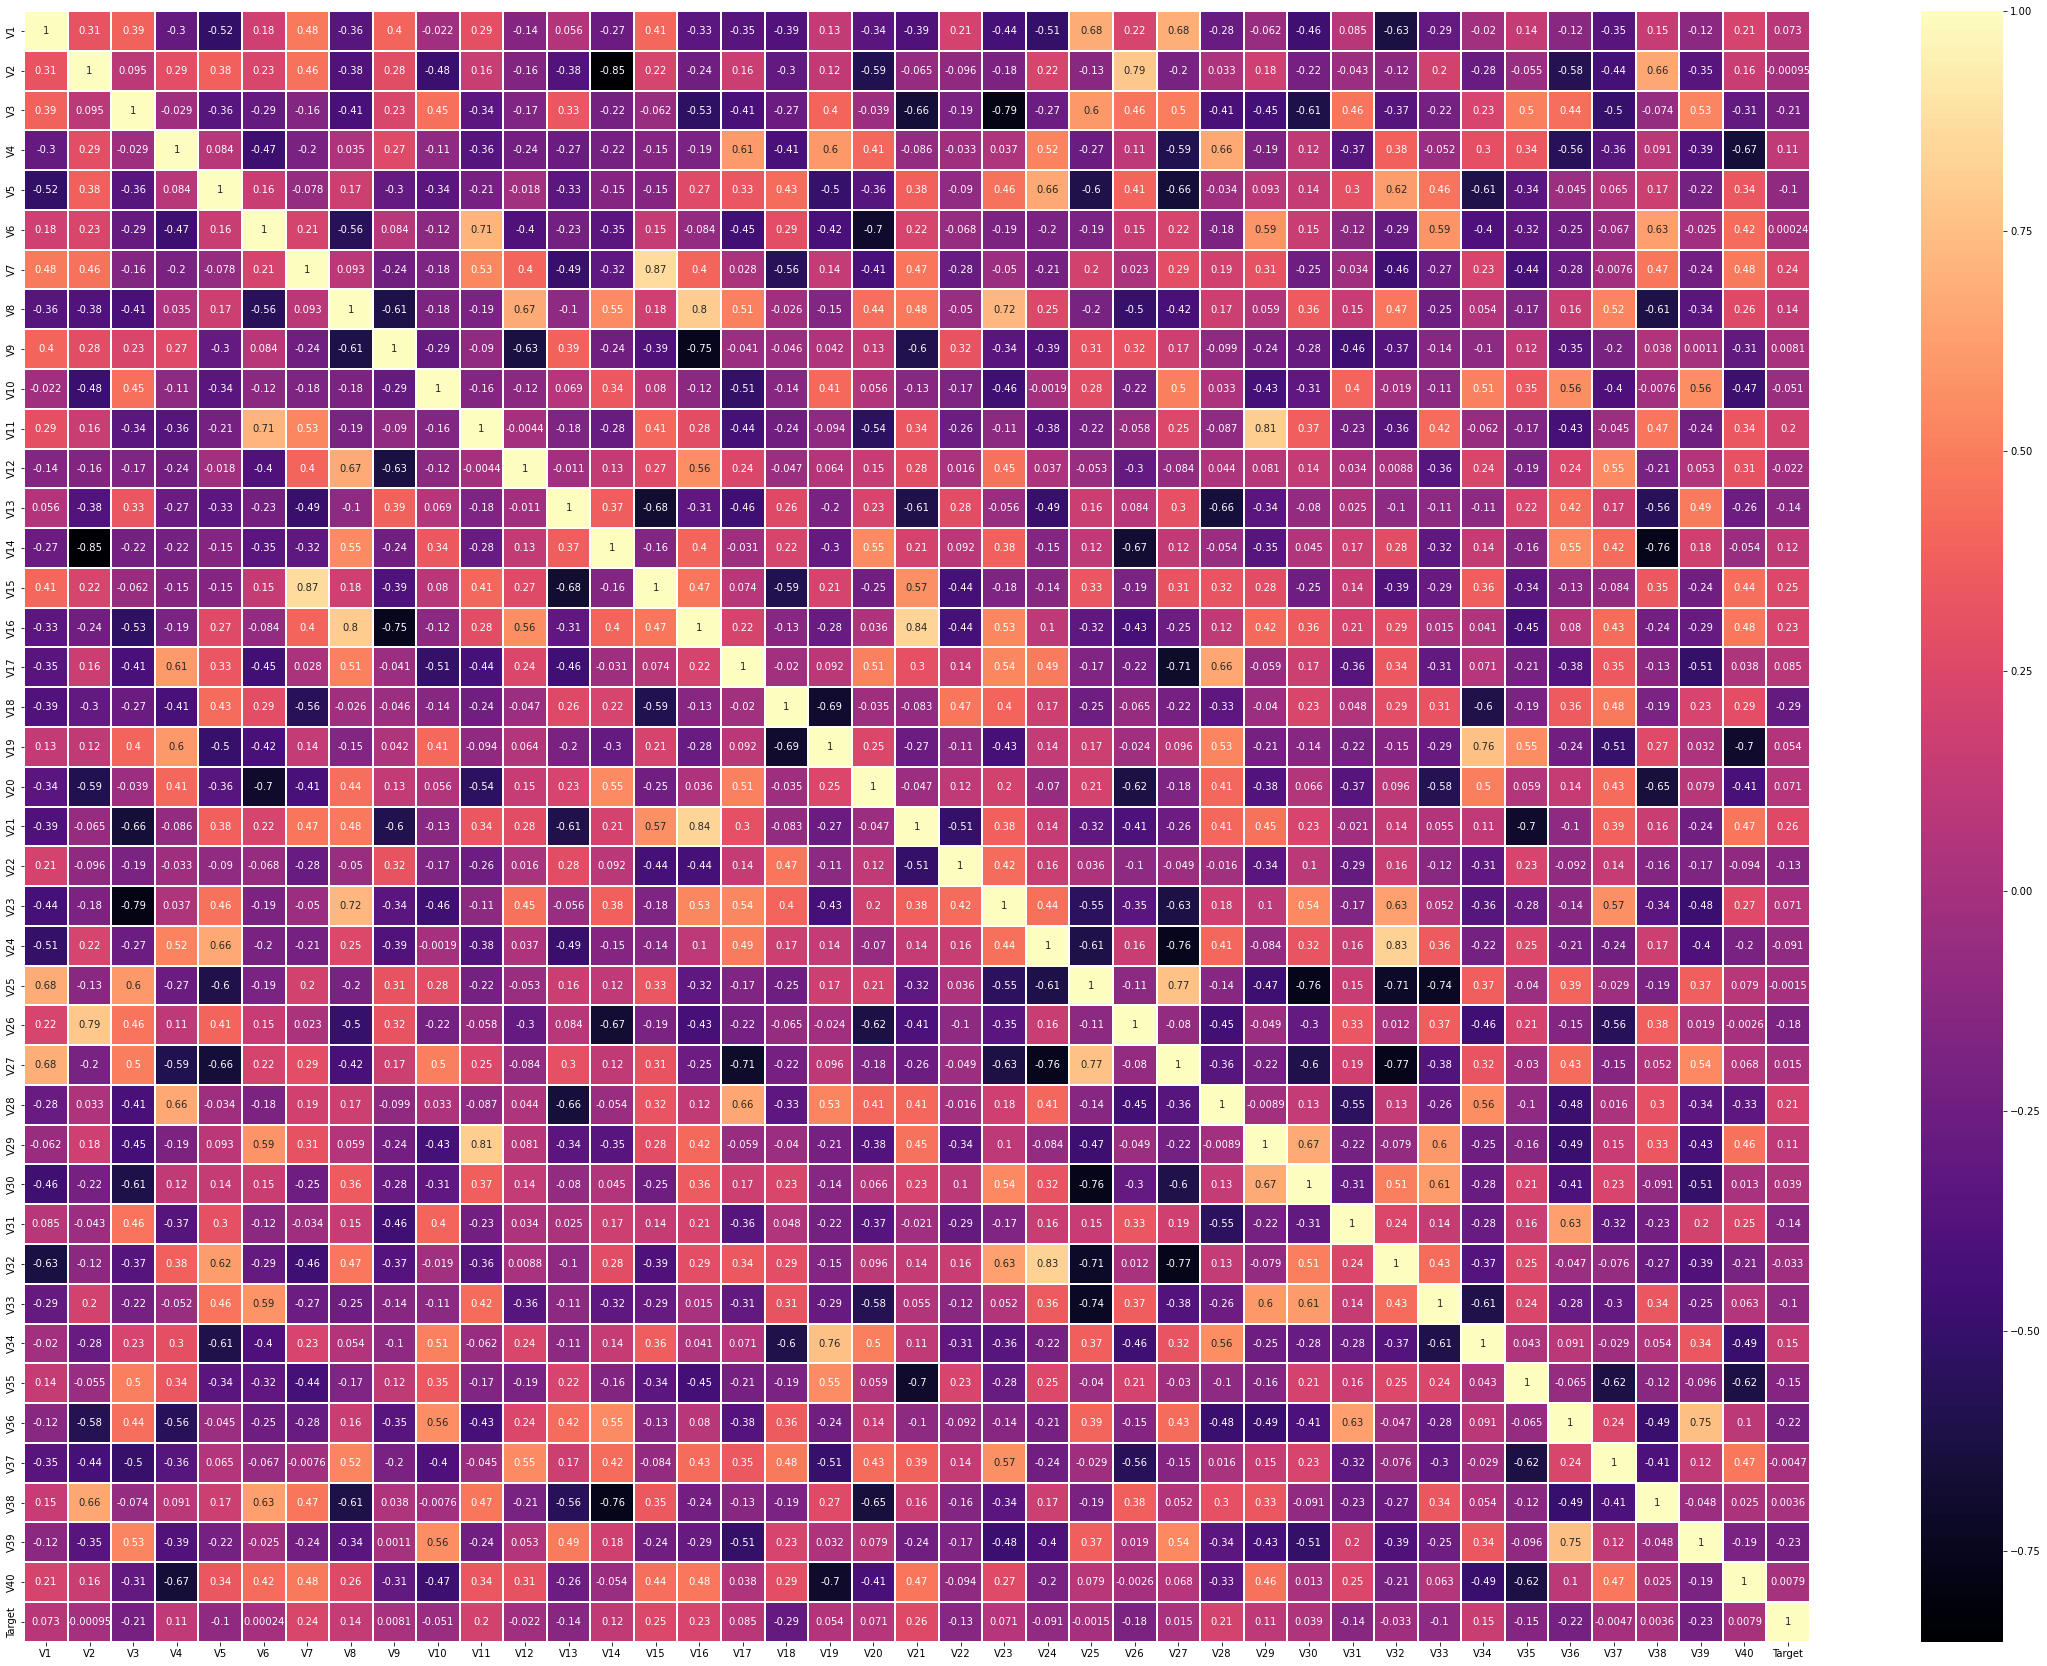

In [26]:
#creating a heat map to note correlation
#particularly reviewing correlation to target variable 

fig,ax = plt.subplots(figsize=(40,30))
sns.heatmap(train2.corr(), ax=ax, annot=True, linewidths=0.05,cmap='magma') 	
#color intensity 
plt.show()


**Observations on correlation**

- No significant correlation between any of the variables and the target variable 
    - Highest correlations are V18 (-0.29), V7 (0.24), and V15 (0.25) 
    - This is still really low 
- some higher correlation between individual variables, but since we're using ensemble methods I will not drop any 
    - V2 & V14: -0.85
    - V3 & V21 -0.66
    - V3 & V23 -.79
    - V4 & V40 0.67
    - V5 & V27 0.66
    - V6 & V20 -0.7
    - V9 & V16 -0.75
    - V13 & V15 -0.68

## EDA Summary and changes:
 - **Missing Values**
     - There are n/a values that I dropped for var1 and 2
 - **Distributions**
     - all variables are normally distributed 
     - some have slight skew but not enough to require transformation
     - none appear to be dummy variables/onehot encoded, nor do they need to be transformed as such 
     - some variables have wider distribution than others
         - most variables fall within +/- 10, with a few having outliers out to 20
     - some variables had significantly different distribution for rows that failed (target = 1) than not
         - Note on individual variables above commenting on specific ranges/tails on the failed rows that differed from nonfailure rows 
         - I'm curious if these variables show up in the models 
         -  following values may be indicators of failure
             - V3 <-5
             - V7 >4 
             - V8 <10
             - V11 <-10
             - V12 <-17 or >12 
             - V13 <-9
             - V16 >5
             - V18 <-5
             - V21 >5
             - V22 <-4 
             - V23 >5 (weak) 
             - V24 <-10 
             - V28 >4 (weak)
             - V31 <-10 (weak) 
             - V35 <-5 
             - V39 <-3 
 - **Outliers** 
    - few variables have lines outside the 4 X IQR range 
    - V13, V15, V18, V22, V34, V35 do 
    - Will trim the whiskers to match 4XIQR value 
 - **Correlation**
     - Some variables were correlated to one another, but as we are approaching with ensemble method I will not remove 
     - No variables significantly correlated to target unfortunately 
         - V7, V15, and V18 had slight correlation (~.25) but that's still quite low 

## Data Pre-processing

- The following variables have lines outside the 4XIQR range
  - V13, V15, V18, V22, V34, V35 do 
- I will change those to na, then redefine them as the +/- 4 X IQR number 


In [27]:
#changing V13 outliers to 4 X IQR value 
v13_4iqr = 4*((np.quantile(train2['V13'], 0.75))-(np.quantile(train2['V13'], 0.25)))
v13_outliers = train2[ (abs(train2['V13'])>v13_4iqr) ]
print("V13 outlier threshold: ",v13_4iqr)
print("Total V13 Outliers: ",len(v13_outliers))

V13 outlier threshold:  14.735603487999999
Total V13 Outliers:  1


In [28]:
v13_outliers

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
3409,4.028,-4.812,1.747,-2.782,-8.603,-0.267,-1.287,-5.073,4.422,2.165,7.823,2.457,15.420,1.188,-10.056,-7.444,-13.348,-2.413,5.671,0.321,-12.199,3.465,-1.513,-11.925,-1.543,-0.543,10.337,-4.060,-0.237,4.245,-8.761,-7.306,0.912,4.086,7.563,-1.659,-0.670,-2.045,3.195,-10.092,1


In [29]:
#redefining outlier as 4XIQR 
train2['V13'].loc[[3409]]=14.735603487999999

In [30]:
train2.loc[[3409]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
3409,4.028,-4.812,1.747,-2.782,-8.603,-0.267,-1.287,-5.073,4.422,2.165,7.823,2.457,14.736,1.188,-10.056,-7.444,-13.348,-2.413,5.671,0.321,-12.199,3.465,-1.513,-11.925,-1.543,-0.543,10.337,-4.060,-0.237,4.245,-8.761,-7.306,0.912,4.086,7.563,-1.659,-0.670,-2.045,3.195,-10.092,1


In [31]:
#changing V15 outliers to 4 X IQR value 
v15_4iqr = 4*((np.quantile(train2['V15'], 0.75))-(np.quantile(train2['V15'], 0.25)))
v15_outliers = train2[ (abs(train2['V15'])>v15_4iqr) ]
print("V15 outlier threshold: ",v15_4iqr)
print("Total V15 Outliers: ",len(v15_outliers))

V15 outlier threshold:  16.217420330000003
Total V15 Outliers:  2


In [32]:
v15_outliers

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
7234,-4.395,-0.929,0.541,-5.002,3.046,3.069,-6.389,-6.456,4.008,-2.513,-1.825,-3.824,10.339,-0.447,-16.284,-10.480,-6.056,11.004,-9.498,-3.686,-9.873,3.829,2.638,-0.411,-3.682,6.938,-3.350,-6.488,-0.325,3.770,-0.564,5.586,9.646,-11.293,2.210,3.594,1.450,-2.502,2.890,-0.642,0
10406,-4.632,-5.475,1.817,-5.142,2.335,0.204,-7.950,-2.418,4.026,-1.893,-7.048,-3.875,11.192,2.657,-16.417,-9.128,-2.962,12.053,-11.243,2.893,-9.920,4.180,3.946,-1.469,-0.901,2.847,-2.803,-6.410,-3.633,1.837,1.768,6.864,4.462,-10.563,1.667,8.475,3.021,-10.716,3.089,0.095,0


In [33]:
#redefining outlier as 4XIQR 
train2['V15'].loc[[7234,10406]]=-16.217420330000003
train2.loc[[7234,10406]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
7234,-4.395,-0.929,0.541,-5.002,3.046,3.069,-6.389,-6.456,4.008,-2.513,-1.825,-3.824,10.339,-0.447,-16.217,-10.480,-6.056,11.004,-9.498,-3.686,-9.873,3.829,2.638,-0.411,-3.682,6.938,-3.350,-6.488,-0.325,3.770,-0.564,5.586,9.646,-11.293,2.210,3.594,1.450,-2.502,2.890,-0.642,0
10406,-4.632,-5.475,1.817,-5.142,2.335,0.204,-7.950,-2.418,4.026,-1.893,-7.048,-3.875,11.192,2.657,-16.217,-9.128,-2.962,12.053,-11.243,2.893,-9.920,4.180,3.946,-1.469,-0.901,2.847,-2.803,-6.410,-3.633,1.837,1.768,6.864,4.462,-10.563,1.667,8.475,3.021,-10.716,3.089,0.095,0


In [34]:
#v18 outlier whisker trim 
v18_4iqr = 4*((np.quantile(train2['V18'], 0.75))-(np.quantile(train2['V18'], 0.25)))
v18_outliers = train2[ (abs(train2['V18'])>v18_4iqr) ]
print("V18 outlier threshold: ",v18_4iqr)
print("Total V18 Outliers: ",len(v18_outliers))

V18 outlier threshold:  11.899888358
Total V18 Outliers:  5


In [35]:
v18_outliers

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
7516,-2.071,-2.989,-5.291,-8.159,1.365,5.097,-3.932,-4.740,2.880,-3.540,1.203,-1.202,6.031,0.018,-10.817,-7.680,-2.879,12.137,-10.407,-2.239,-5.190,5.554,6.181,-2.311,-2.132,-0.692,-0.913,-3.534,1.876,4.849,-5.754,-0.742,5.921,-9.371,-2.003,1.469,4.401,-0.161,1.634,3.728,0
8344,1.246,-8.907,-0.823,-10.271,-1.081,-1.358,-5.081,3.813,1.866,-3.034,-6.268,3.669,10.261,4.211,-10.978,-4.956,0.049,12.174,-11.249,5.954,-9.253,7.410,9.824,-4.576,2.447,-4.751,1.732,-5.602,-3.662,2.155,0.019,1.040,-3.331,-8.820,0.480,9.917,6.444,-14.924,1.612,5.202,0
10406,-4.632,-5.475,1.817,-5.142,2.335,0.204,-7.950,-2.418,4.026,-1.893,-7.048,-3.875,11.192,2.657,-16.217,-9.128,-2.962,12.053,-11.243,2.893,-9.920,4.180,3.946,-1.469,-0.901,2.847,-2.803,-6.410,-3.633,1.837,1.768,6.864,4.462,-10.563,1.667,8.475,3.021,-10.716,3.089,0.095,0
11522,-4.141,-4.497,-2.513,-5.259,2.029,2.252,-6.412,-3.756,3.870,-2.793,-4.974,-2.668,7.548,1.320,-14.127,-10.224,-0.424,13.180,-10.169,2.281,-7.847,5.932,6.069,-0.167,-1.165,-0.224,-3.111,-3.532,-2.205,2.890,-3.799,3.494,3.600,-9.292,-0.535,4.634,4.240,-5.000,2.349,1.293,0
14775,-4.711,-3.868,-3.025,-4.450,2.795,2.018,-5.619,-3.710,0.786,0.505,-4.631,-0.626,5.796,0.932,-13.332,-9.813,-2.444,12.363,-6.127,-1.786,-8.258,7.119,7.919,6.555,-3.232,0.548,-3.466,-2.472,-3.701,3.620,-1.468,10.173,5.776,-8.187,2.784,4.683,1.833,-0.746,2.200,-1.650,0


In [36]:
#redefining outlier as 4XIQR 
train2['V18'].loc[[7516,8344,10406,11522,14775]]=v18_4iqr
train2.loc[[7516,8344,10406,11522,14775]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
7516,-2.071,-2.989,-5.291,-8.159,1.365,5.097,-3.932,-4.740,2.880,-3.540,1.203,-1.202,6.031,0.018,-10.817,-7.680,-2.879,11.900,-10.407,-2.239,-5.190,5.554,6.181,-2.311,-2.132,-0.692,-0.913,-3.534,1.876,4.849,-5.754,-0.742,5.921,-9.371,-2.003,1.469,4.401,-0.161,1.634,3.728,0
8344,1.246,-8.907,-0.823,-10.271,-1.081,-1.358,-5.081,3.813,1.866,-3.034,-6.268,3.669,10.261,4.211,-10.978,-4.956,0.049,11.900,-11.249,5.954,-9.253,7.410,9.824,-4.576,2.447,-4.751,1.732,-5.602,-3.662,2.155,0.019,1.040,-3.331,-8.820,0.480,9.917,6.444,-14.924,1.612,5.202,0
10406,-4.632,-5.475,1.817,-5.142,2.335,0.204,-7.950,-2.418,4.026,-1.893,-7.048,-3.875,11.192,2.657,-16.217,-9.128,-2.962,11.900,-11.243,2.893,-9.920,4.180,3.946,-1.469,-0.901,2.847,-2.803,-6.410,-3.633,1.837,1.768,6.864,4.462,-10.563,1.667,8.475,3.021,-10.716,3.089,0.095,0
11522,-4.141,-4.497,-2.513,-5.259,2.029,2.252,-6.412,-3.756,3.870,-2.793,-4.974,-2.668,7.548,1.320,-14.127,-10.224,-0.424,11.900,-10.169,2.281,-7.847,5.932,6.069,-0.167,-1.165,-0.224,-3.111,-3.532,-2.205,2.890,-3.799,3.494,3.600,-9.292,-0.535,4.634,4.240,-5.000,2.349,1.293,0
14775,-4.711,-3.868,-3.025,-4.450,2.795,2.018,-5.619,-3.710,0.786,0.505,-4.631,-0.626,5.796,0.932,-13.332,-9.813,-2.444,11.900,-6.127,-1.786,-8.258,7.119,7.919,6.555,-3.232,0.548,-3.466,-2.472,-3.701,3.620,-1.468,10.173,5.776,-8.187,2.784,4.683,1.833,-0.746,2.200,-1.650,0


In [37]:
#v22 whisker trim 
v22_4iqr = 4*((np.quantile(train2['V22'], 0.75))-(np.quantile(train2['V22'], 0.25)))
v22_outliers = train2[ (abs(train2['V22'])>v22_4iqr) ]
print("V22 outlier threshold: ",v22_4iqr)
print("Total V22 Outliers: ",len(v22_outliers))

V22 outlier threshold:  8.574940177999999
Total V22 Outliers:  2


In [38]:
v22_outliers

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
3671,-2.995,2.008,-4.353,2.338,-1.434,2.259,4.448,0.045,2.870,-2.814,11.826,-3.222,2.442,1.525,5.800,13.424,-4.104,-10.677,-2.008,1.095,13.840,-10.122,-6.165,-16.387,-1.586,-0.061,3.323,0.078,7.325,-0.890,-5.922,-12.344,-0.458,7.082,-11.386,-6.592,1.103,1.416,0.827,0.007,1
16537,-5.928,-0.307,-1.415,5.882,-1.570,-0.652,2.019,3.953,-0.540,-2.216,5.910,-0.381,-3.336,-0.062,6.510,11.735,3.519,-8.304,2.932,6.720,11.568,-8.979,-5.779,-7.560,-0.982,-3.704,-3.846,2.949,8.051,3.047,-4.484,-7.034,-0.378,8.121,-5.078,-5.293,1.543,-0.820,-0.655,-0.001,1


In [39]:
#redefining outlier as 4XIQR 

train2['V22'].loc[[3671,16537]] = -8.574940177999999
train2.loc[[3671,16537]]     #checking change 

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
3671,-2.995,2.008,-4.353,2.338,-1.434,2.259,4.448,0.045,2.870,-2.814,11.826,-3.222,2.442,1.525,5.800,13.424,-4.104,-10.677,-2.008,1.095,13.840,-8.575,-6.165,-16.387,-1.586,-0.061,3.323,0.078,7.325,-0.890,-5.922,-12.344,-0.458,7.082,-11.386,-6.592,1.103,1.416,0.827,0.007,1
16537,-5.928,-0.307,-1.415,5.882,-1.570,-0.652,2.019,3.953,-0.540,-2.216,5.910,-0.381,-3.336,-0.062,6.510,11.735,3.519,-8.304,2.932,6.720,11.568,-8.575,-5.779,-7.560,-0.982,-3.704,-3.846,2.949,8.051,3.047,-4.484,-7.034,-0.378,8.121,-5.078,-5.293,1.543,-0.820,-0.655,-0.001,1


In [40]:
#v34 whisker trim 
v34_4iqr = 4*((np.quantile(train2['V34'], 0.75))-(np.quantile(train2['V34'], 0.25)))
v34_outliers = train2[ (abs(train2['V34'])>v34_4iqr) ]
print("V34 outlier threshold: ",v34_4iqr)
print("Total V34 Outliers: ",len(v34_outliers))

V34 outlier threshold:  14.297676688
Total V34 Outliers:  6


In [41]:
v34_outliers['V34']

1180    -17.985
4329    -14.822
6331    -15.966
11695    14.358
14215   -14.674
14387   -14.830
Name: V34, dtype: float64

In [42]:
#redefining outlier as 4XIQR 

train2['V34'].loc[[1180,4329,6331,14215,14387]] = -v34_4iqr
train2['V34'].loc[[11695]] = v34_4iqr
train2['V34'].loc[[1180,4329,6331,14215,14387,11695]]     #checking change 

1180    -14.298
4329    -14.298
6331    -14.298
14215   -14.298
14387   -14.298
11695    14.298
Name: V34, dtype: float64

In [43]:
#v35 whisker trim 
v35_4iqr = 4*((np.quantile(train2['V35'], 0.75))-(np.quantile(train2['V35'], 0.25)))
v35_outliers = train2[ (abs(train2['V35'])>v35_4iqr) ]
print("V35 outlier threshold: ",v35_4iqr)
print("Total V35 Outliers: ",len(v35_outliers))

V35 outlier threshold:  14.929977729
Total V35 Outliers:  2


In [44]:
v35_outliers['V35']

3630   -15.350
6794    15.291
Name: V35, dtype: float64

In [45]:
#redefining outlier as 4XIQR 

train2['V35'].loc[[3630]] = -v35_4iqr
train2['V35'].loc[[6794]] = v35_4iqr
train2['V35'].loc[[3630,6794]]     #checking change 

3630   -14.930
6794    14.930
Name: V35, dtype: float64

#### Splitting the data 

In [52]:
#Splitting train data into data and target 
X_temp = train2.drop(columns="Target")
y_temp = train2['Target']

#splitting test data into data and target 
X_test = test2.drop(columns="Target")
y_test = test2['Target']

In [53]:
#splitting the train data into train and validate 
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(14973, 40) (4991, 40) (4989, 40)


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

### Which metric to optimize?

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [54]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

In [55]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [56]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

utilizing sample decision tree format to build out 6 models 

In [57]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Bagging: 0.7043864079070773
Random forest: 0.7127624269533224
GBM: 0.7163696702979583
Adaboost: 0.6081523699588774
Xgboost: 0.7885361806507467
dtree: 0.7212105908664598

Validation Performance:

Bagging: 0.6942446043165468
Random forest: 0.7446043165467626
GBM: 0.7482014388489209
Adaboost: 0.6330935251798561
Xgboost: 0.8201438848920863
dtree: 0.7086330935251799


Observation: From initial data, 
- Xgboost shows the best scores but does have the highest cost as well

### Model Building with Oversampled data


In [60]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [63]:
#re-running all models with over-sampled data 

models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost - Over-sampled:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance - Over-sampled:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost - Over-sampled:

Bagging: 0.9776536758356945
Random forest: 0.9845836689410495
GBM: 0.9292833419078917
Adaboost: 0.9025532685066718
Xgboost: 0.9897458530885659
dtree: 0.9731987052666786

Validation Performance - Over-sampled:

Bagging: 0.8489208633093526
Random forest: 0.841726618705036
GBM: 0.8741007194244604
Adaboost: 0.8525179856115108
Xgboost: 0.8597122302158273
dtree: 0.7985611510791367


Observations: 
- cost increased substantially across all models with over-sampling
- validation scores also creased across the board
    - GBM followed by Xgboost best scores 

### Model Building with Undersampled data

In [65]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [66]:
#re-running all models with under-sampled data 

models_under = []  # Empty list to store all the models

# Appending models into the list
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("Random forest", RandomForestClassifier(random_state=1)))
models_under.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_under.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models_under.append(("dtree", DecisionTreeClassifier(random_state=1)))

results_under = []  # Empty list to store all model's CV scores
names_under = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost - Under-sampled:" "\n")

for name, model in models_under:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_under.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance - Under-sampled:" "\n")

for name, model in models_under:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost - Under-sampled:

Bagging: 0.8858235336555804
Random forest: 0.8990693312170839
GBM: 0.9038886083255177
Adaboost: 0.8629968977707236
Xgboost: 0.9050789986292476
dtree: 0.8569655868984922

Validation Performance - Under-sampled:

Bagging: 0.8741007194244604
Random forest: 0.8848920863309353
GBM: 0.8920863309352518
Adaboost: 0.8525179856115108
Xgboost: 0.8920863309352518
dtree: 0.8453237410071942


Observations: 
- compared to oversampling, undersampling reduced cost but increased some scores
- Xgboost and gradientboost are both still the highest scorers 
    - also the highest cost 

## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Sample tuning method for Decision tree with original data

In [64]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7], 
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.5734362600101003:


### Sample tuning method for Decision tree with oversampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7], 
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

### Sample tuning method for Decision tree with undersampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7], 
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

### Tuning Bagging model with original data

In [71]:
#Tuning model with RandomizedSearchCV

# defining model
bagging_original_tuned = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9], 
              'n_estimators' : [30,50,70], }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=bagging_original_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.9} with CV score=0.7296515402929081:


In [72]:
#building model using best parameters 
bagging_original_tuned = BaggingClassifier(
    max_samples=0.9,
    max_features=0.9,
    n_estimators=70,
    random_state=1)

#fit the model on training data
bagging_original_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=70,
                  random_state=1)

In [73]:
#calculating metrics on train and validation set 
bagging_original_tuned_train = model_performance_classification_sklearn(bagging_original_tuned, X_train, y_train)
bagging_original_tuned_perf = model_performance_classification_sklearn(bagging_original_tuned, X_val, y_val)

print("Training performance - bagging_original_tuned:")
bagging_original_tuned_train

Training performance - bagging_original_tuned:


,Accuracy,Recall,Precision,F1
0,1.000,0.993,1.000,0.996


In [74]:
print("Validation performance - bagging_original_tuned:")
bagging_original_tuned_perf

Validation performance - bagging_original_tuned:


,Accuracy,Recall,Precision,F1
0,0.984,0.748,0.950,0.837


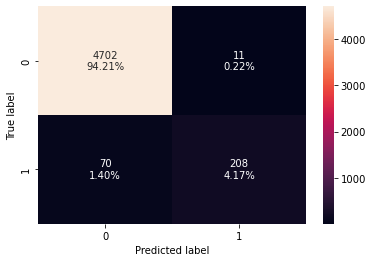

In [75]:
#creating confusion matrix
confusion_matrix_sklearn(bagging_original_tuned, X_val, y_val)

Observation:

Overall score: 
- tuning significantly improved from the bagging model with original data, from 0.6942 to 0.7297
- However, this score is still lower than other models we created with under and oversampled data 

Train vs validation scores: 
- model performs extremely well on training data
- moderately well on validation data, with recall 0.74 
- this points to some overfitting 

### Tuning Bagging model with oversampled data

In [68]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9], 
              'n_estimators' : [30,50,70], }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.9833105595061854:


In [76]:
#building model using best parameters 
bagging_over_tuned = BaggingClassifier(
    max_samples=0.9,
    max_features=0.8,
    n_estimators=70,
    random_state=1)

#fit the model on training data
bagging_over_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=70,
                  random_state=1)

In [77]:
#calculating metrics on train and validation set 
bagging_over_tuned_train = model_performance_classification_sklearn(bagging_over_tuned, X_train, y_train)
bagging_over_tuned_perf = model_performance_classification_sklearn(bagging_over_tuned, X_val, y_val)

print("Training performance - bagging_original_tuned:")
bagging_over_tuned_train

Training performance - bagging_original_tuned:


,Accuracy,Recall,Precision,F1
0,1.000,0.993,1.000,0.996


In [163]:
print("Validation performance - bagging_original_tuned:")
bagging_over_tuned_perf

Validation performance - bagging_original_tuned:


,Accuracy,Recall,Precision,F1
0,0.984,0.748,0.963,0.842


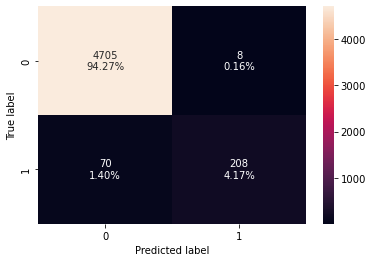

In [79]:
#creating confusion matrix
confusion_matrix_sklearn(bagging_over_tuned, X_val, y_val)

Observation: 

Overall score: 
- Tuning bagging model with oversampled data had an incredible score at 0.983 
- tuning on oversampled data recommended same parameters as original but 0.8 max features instead of 0.9 

Training vs validation: 
- Similar to the original data tuned model, the oversampled model had high scores on training data and ok scores on validation
- both returned recall scores of 0.748 
- tuned bagging with oversampled data had slightly higher precision on validadtion 

### Tuning Bagging model with undersampled data

In [69]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9], 
              'n_estimators' : [30,50,70], }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.9} with CV score=0.8978212250198399:


In [80]:
#building model using best parameters 
bagging_under_tuned = BaggingClassifier(
    max_samples=0.9,
    max_features=0.9,
    n_estimators=70,
    random_state=1)

#fit the model on training data
bagging_under_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=70,
                  random_state=1)

In [81]:
#calculating metrics on train and validation set 
bagging_under_tuned_train = model_performance_classification_sklearn(bagging_under_tuned, X_train, y_train)
bagging_under_tuned_perf = model_performance_classification_sklearn(bagging_under_tuned, X_val, y_val)

print("Training performance:")
bagging_under_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,0.993,1.000,0.996


In [82]:
print("Validation performance:")
bagging_under_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.984,0.748,0.950,0.837


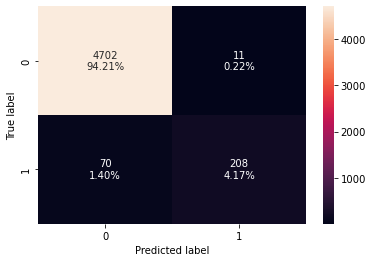

In [83]:
#creating confusion matrix
confusion_matrix_sklearn(bagging_under_tuned, X_val, y_val)

Observation: 

Overall score: 
- Overall score not as high as tuned with oversampled data, but still solid: 
- 0.8978212250198399

Train vs validation: 
- similar to other tuned bagging models, this performed extremely well on training and ok on validation 
- recall still at 0.748
- predision dipped from the oversampled data (.96) down to 0.95
- F1 score also dipped from 0.84 to 0.83 

**So far, Tuning with oversampled data is the strongest bagging model**

### Tuning Random Forest model with original data

In [84]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], 
              "min_samples_leaf": np.arange(1, 4), 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], 
              "max_samples": np.arange(0.4, 0.7, 0.1) }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6911983262390882:


In [86]:
#building model using best parameters 
rf_original_tuned = RandomForestClassifier(
    max_samples=0.6,
    max_features='sqrt',
    n_estimators=250,
    min_samples_leaf=1,
    random_state=1)

#fit the model on training data
rf_original_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=250,
                       random_state=1)

In [87]:
#calculating metrics on train and validation set 
rf_original_tuned_train = model_performance_classification_sklearn(rf_original_tuned, X_train, y_train)
rf_original_tuned_perf = model_performance_classification_sklearn(rf_original_tuned, X_val, y_val)

print("Training performance:")
rf_original_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.911,0.999,0.953


In [88]:
print("Validation performance:")
rf_original_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.984,0.727,0.985,0.836


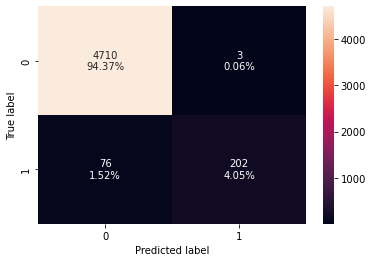

In [89]:
#creating confusion matrix
confusion_matrix_sklearn(rf_original_tuned, X_val, y_val)

Observation: 

overall score: 
- cv score with tuned random forest is only 0.67 

Train vs validation: 
- less overfitting than the bagging models 
- almost no Flse Positives 
- more False negatives 
- Recall score down to 0.72, but precision is quite high 
- we want to prioritize recall, not the best 

### Tuning Random Forest model with oversampled data

In [90]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], 
              "min_samples_leaf": np.arange(1, 4), 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], 
              "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9816840682704842:


In [93]:
#building model using best parameters 
rf_over_tuned = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=1,
    max_features='sqrt',
    max_samples=0.6,
    random_state=1)

#fit the model on training data
rf_over_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=300,
                       random_state=1)

In [94]:
#calculating metrics on train and validation set 
rf_over_tuned_train = model_performance_classification_sklearn(rf_over_tuned, X_train, y_train)
rf_over_tuned_perf = model_performance_classification_sklearn(rf_over_tuned, X_val, y_val)

print("Training performance:")
rf_over_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.907,0.999,0.951


In [95]:
print("Validation performance:")
rf_over_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.984,0.730,0.985,0.839


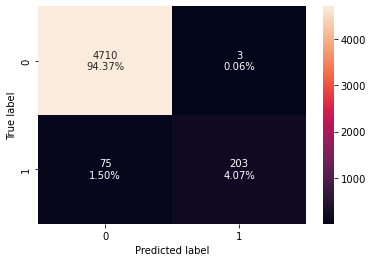

In [96]:
#creating confusion matrix
confusion_matrix_sklearn(rf_over_tuned, X_val, y_val)

Observation: 

Overall score: 
- wow 0.98 overall score, super strong 

Training vs Validation: 
- recall score slightly better than rf tuned with original data (0.73 from 0.72) 
- still very few false positives 
- think we can keep improving 

### Tuning Random Forest model with undersampled data

In [97]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], 
              "min_samples_leaf": np.arange(1, 4), 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], 
              "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.8954115864656229:


In [98]:
#building model using best parameters 
rf_under_tuned = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=1,
    max_features='sqrt',
    max_samples=0.6,
    random_state=1)

#fit the model on training data
rf_under_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=300,
                       random_state=1)

In [99]:
#calculating metrics on train and validation set 
rf_under_tuned_train = model_performance_classification_sklearn(rf_under_tuned, X_train, y_train)
rf_under_tuned_perf = model_performance_classification_sklearn(rf_under_tuned, X_val, y_val)

print("Training performance:")
rf_under_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.907,0.999,0.951


In [164]:
print("Validation performance:")
rf_under_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.984,0.730,0.985,0.839


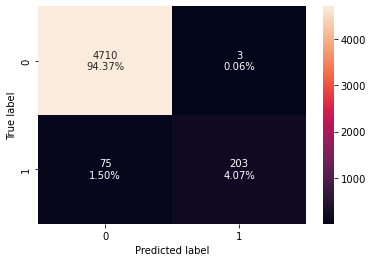

In [101]:
#creating confusion matrix
confusion_matrix_sklearn(rf_under_tuned, X_val, y_val)

Observation: 

Overall score: 
-  lower score than rf tuned with original oversampled data (.89 from .98

Training vs Validation: 
- same recall as oversampled data (0.73) 
- almost exactly the same confusion matrix 

### Tuning Gradient boosting model with original data

In [102]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), 
              "learning_rate": [0.2, 0.05, 1], 
              "subsample":[0.5,0.7], 
              "max_features":[0.5,0.7] }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7488853618065076:


In [103]:
#building model using best parameters 
gbm_original_tuned = GradientBoostingClassifier(
    subsample=0.7,
    n_estimators=125,
    max_features=0.5,
    learning_rate=0.2,
    random_state=1)

#fit the model on training data
gbm_original_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [104]:
#calculating metrics on train and validation set 
gbm_original_tuned_train = model_performance_classification_sklearn(gbm_original_tuned, X_train, y_train)
gbm_original_tuned_perf = model_performance_classification_sklearn(gbm_original_tuned, X_val, y_val)

print("Training performance:")
gbm_original_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.994,0.917,0.971,0.943


In [105]:
print("Validation performance:")
gbm_original_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.981,0.784,0.858,0.820


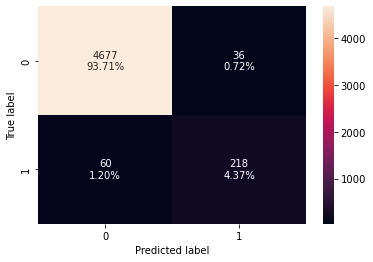

In [106]:
#creating confusion matrix
confusion_matrix_sklearn(gbm_original_tuned, X_val, y_val)

Observation: 

Overall score: 
- overall score quite low compared to the others we've seen (0.74)

Training vs Validation: 
- high accuracy and precision and F1
- highest recall of all tuned models, but not as high as some untuned  

### Tuning Gradient boosting model with oversampled data

In [107]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), 
              "learning_rate": [0.2, 0.05, 1], 
              "subsample":[0.5,0.7], 
              "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9734810657251151:


In [108]:
#building model using best parameters 
gbm_over_tuned = GradientBoostingClassifier(
    subsample=0.7,
    n_estimators=125,
    max_features=0.5,
    learning_rate=1,
    random_state=1)

#fit the model on training data
gbm_over_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [166]:
#calculating metrics on train and validation set 
gbm_over_tuned_train = model_performance_classification_sklearn(gbm_over_tuned, X_train, y_train)
gbm_over_tuned_perf = model_performance_classification_sklearn(gbm_over_tuned, X_val, y_val)

print("Training performance:")
gbm_over_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.980,0.733,0.883,0.801


In [167]:
print("Validation performance:")
gbm_over_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.966,0.619,0.735,0.672


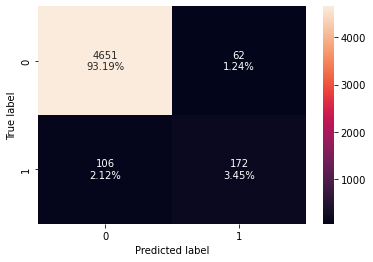

In [111]:
#creating confusion matrix
confusion_matrix_sklearn(gbm_over_tuned, X_val, y_val)

Observation: 

Overall score: 
- 0.97 - huge improvement from tuned original model 

Training vs Validation: 
- unfortunately, recall is significantly lower with increased false positives and false negatives 
- 0.61, almost the worst across all models 

### Tuning Gradient boosting model with undersampled data

In [112]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), 
              "learning_rate": [0.2, 0.05, 1], 
              "subsample":[0.5,0.7], 
              "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.9050357117091119:


In [113]:
#building model using best parameters 
gbm_under_tuned = GradientBoostingClassifier(
    subsample=0.7,
    n_estimators=125,
    max_features=0.5,
    learning_rate=0.2,
    random_state=1)

#fit the model on training data
gbm_under_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [114]:
#calculating metrics on train and validation set 
gbm_under_tuned_train = model_performance_classification_sklearn(gbm_under_tuned, X_train, y_train)
gbm_under_tuned_perf = model_performance_classification_sklearn(gbm_under_tuned, X_val, y_val)

print("Training performance:")
gbm_under_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.994,0.917,0.971,0.943


In [165]:
print("Validation performance:")
gbm_under_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.981,0.784,0.858,0.820


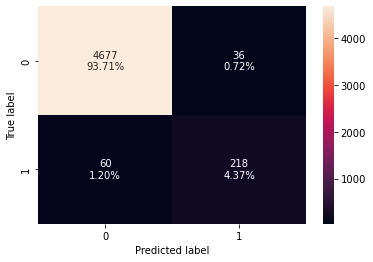

In [116]:
#creating confusion matrix
confusion_matrix_sklearn(gbm_under_tuned, X_val, y_val)

Observation: 

Overall score: 
- slight dip from oversampled score, down to 0.9 

Training vs Validation: 
- recall has improved to 0.78 but that is still not the strongest model we've seen 
- accuracy and precision are still quite high though 

### Tuning Adaboost model with original data

In [117]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], 
              "learning_rate": [0.2, 0.05], 
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1), 
                                ] }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.7644542240819565:


In [118]:
#building model using best parameters 
ada_original_tuned = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
    random_state=1)

#fit the model on training data
ada_original_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

In [119]:
#calculating metrics on train and validation set 
ada_original_tuned_train = model_performance_classification_sklearn(ada_original_tuned, X_train, y_train)
ada_original_tuned_perf = model_performance_classification_sklearn(ada_original_tuned, X_val, y_val)

print("Training performance:")
ada_original_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999,0.986,1.000,0.993


In [120]:
print("Validation performance:")
ada_original_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.985,0.759,0.963,0.849


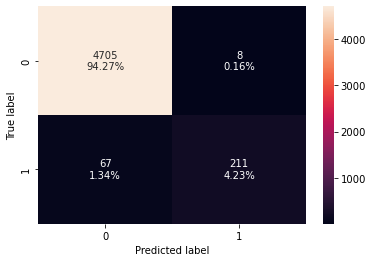

In [121]:
#creating confusion matrix
confusion_matrix_sklearn(ada_original_tuned, X_val, y_val)

Observation: 

Overall score: 
- not so hot = 0.76, but curious about the recall adjustment 

Training vs Validation: 
- Data performed extremely well on train and pretty great on test 
- recall still not as strong as other untuned models, but higher than most other tuned models (0.75) 
- very few false positives, but pretty high count of false negatives 

### Tuning Adaboost model with oversampled data

In [122]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], 
              "learning_rate": [0.2, 0.05], 
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1), 
                                ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9746833288085665:


In [123]:
#building model using best parameters 
ada_over_tuned = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
    random_state=1)

#fit the model on training data
ada_over_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

In [124]:
#calculating metrics on train and validation set 
ada_over_tuned_train = model_performance_classification_sklearn(ada_over_tuned, X_train, y_train)
ada_over_tuned_perf = model_performance_classification_sklearn(ada_over_tuned, X_val, y_val)

print("Training performance:")
ada_over_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999,0.986,1.000,0.993


In [125]:
print("Validation performance:")
ada_over_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.985,0.759,0.963,0.849


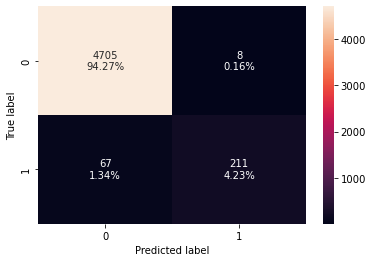

In [126]:
#creating confusion matrix
confusion_matrix_sklearn(ada_over_tuned, X_val, y_val)

Observation: 

Overall score: 
- even better! 0.97, improving well 

Training vs Validation: 
- slightly overfit on training data, but still a stronger score than we've seen so far 
- accuracy and precision are fantastic on validation, recall still <.8 

### Tuning Adaboost model with undersampled data

In [127]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], 
              "learning_rate": [0.2, 0.05], 
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1), 
                                ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.8990621167303946:


In [128]:
#building model using best parameters 
ada_under_tuned = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
    random_state=1)

#fit the model on training data
ada_under_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

In [129]:
#calculating metrics on train and validation set 
ada_under_tuned_train = model_performance_classification_sklearn(ada_under_tuned, X_train, y_train)
ada_under_tuned_perf = model_performance_classification_sklearn(ada_under_tuned, X_val, y_val)

print("Training performance:")
ada_under_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999,0.986,1.000,0.993


In [130]:
print("Validation performance:")
ada_under_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.985,0.759,0.963,0.849


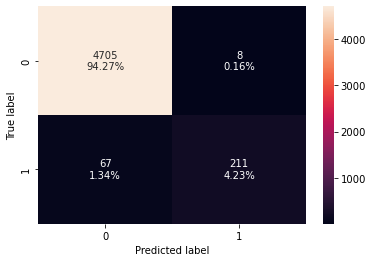

In [131]:
#creating confusion matrix
confusion_matrix_sklearn(ada_under_tuned, X_val, y_val)

Observation: 

Overall score: 
- 0.89 - very strong for the original data 

Training vs Validation: 
- similar to the original data, etremely strong accuracy and precision
- slightly improved recall but still lower than other models 

### Tuning xgboost model with original data

In [132]:
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250], 
            'scale_pos_weight': [5,10], 
            'learning_rate': [0.1,0.2], 
            'gamma': [0,3,5], 
            'subsample': [0.8,0.9] }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.846194358271409:


In [133]:
#building model using best parameters 
xgb_original_tuned = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=150,
    learning_rate=0.1,
    gamma=3,
    random_state=1)

#fit the model on training data
xgb_original_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [134]:
#calculating metrics on train and validation set 
xgb_original_tuned_train = model_performance_classification_sklearn(xgb_original_tuned, X_train, y_train)
xgb_original_tuned_perf = model_performance_classification_sklearn(xgb_original_tuned, X_val, y_val)

print("Training performance:")
xgb_original_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.989,0.995


In [135]:
print("Validation performance:")
xgb_original_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.989,0.849,0.948,0.896


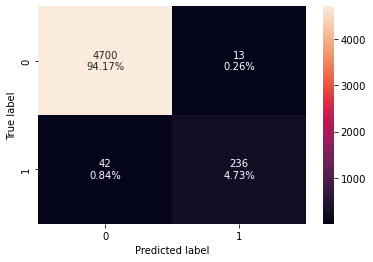

In [136]:
#creating confusion matrix
confusion_matrix_sklearn(xgb_original_tuned, X_val, y_val)

Observation: 

Overall score: 
- pretty strong score at 0.84 with original data but not the strongest we've seen

Training vs Validation: 
- excellent recall AND precision AND accuracy

### Tuning xgboost model with oversampled data

In [137]:
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250], 
            'scale_pos_weight': [5,10], 
            'learning_rate': [0.1,0.2], 
            'gamma': [0,3,5], 
            'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9960398039500966:


In [138]:
#building model using best parameters 
xgb_over_tuned = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=200,
    learning_rate=0.1,
    gamma=5,
    random_state=1)

#fit the model on training data
xgb_over_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [139]:
#calculating metrics on train and validation set 
xgb_over_tuned_train = model_performance_classification_sklearn(xgb_over_tuned, X_train, y_train)
xgb_over_tuned_perf = model_performance_classification_sklearn(xgb_over_tuned, X_val, y_val)

print("Training performance:")
xgb_over_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.987,0.993


In [140]:
print("Validation performance:")
xgb_over_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.990,0.867,0.953,0.908


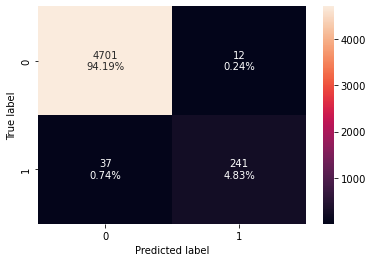

In [141]:
#creating confusion matrix
confusion_matrix_sklearn(xgb_over_tuned, X_val, y_val)

Observation: 

Overall score: 
- realy stellar score - .99

Training vs Validation: 
- accuracy and precision remained solid in the high .90's 
- recall increased to 0.86, just shy of the xgboost untuned on undersampled data (.89) 

### Tuning xgboost model with undersampled data

In [142]:
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250], 
            'scale_pos_weight': [5,10], 
            'learning_rate': [0.1,0.2], 
            'gamma': [0,3,5], 
            'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9218671091551836:


In [143]:
#building model using best parameters 
xgb_under_tuned = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=200,
    learning_rate=0.1,
    gamma=5,
    random_state=1)

#fit the model on training data
xgb_under_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [144]:
#calculating metrics on train and validation set 
xgb_under_tuned_train = model_performance_classification_sklearn(xgb_under_tuned, X_train, y_train)
xgb_under_tuned_perf = model_performance_classification_sklearn(xgb_under_tuned, X_val, y_val)

print("Training performance:")
xgb_under_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.987,0.993


In [145]:
print("Validation performance:")
xgb_under_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.990,0.867,0.953,0.908


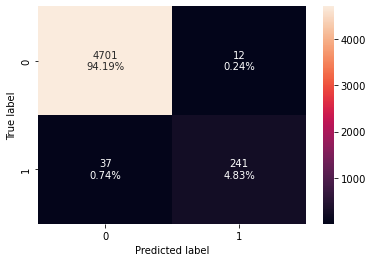

In [146]:
#creating confusion matrix
confusion_matrix_sklearn(xgb_under_tuned, X_val, y_val)

Observation: 

Overall score: 
- score dipped a bit from oversampled down to 0.92 

Training vs Validation: 
- very similar results for validation data, 0.86 recall 
- accuracy and precision still in the high .90's 

### Tuning decision tree model with original data

In [147]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_depth': np.arange(2,6), 
              'min_samples_leaf': [1, 4, 7], 
              'max_leaf_nodes' : [10, 15], 
              'min_impurity_decrease': [0.0001,0.001] }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.5734362600101003:


In [149]:
#building model using best parameters 
dtree_original_tuned = DecisionTreeClassifier(
    min_samples_leaf=7,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=15,
    max_depth=5,
    random_state=1)

#fit the model on training data
dtree_original_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

In [150]:
#calculating metrics on train and validation set 
dtree_original_tuned_train = model_performance_classification_sklearn(dtree_original_tuned, X_train, y_train)
dtree_original_tuned_perf = model_performance_classification_sklearn(dtree_original_tuned, X_val, y_val)

print("Training performance:")
dtree_original_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.974,0.572,0.922,0.706


In [151]:
print("Validation performance:")
dtree_original_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.970,0.543,0.858,0.665


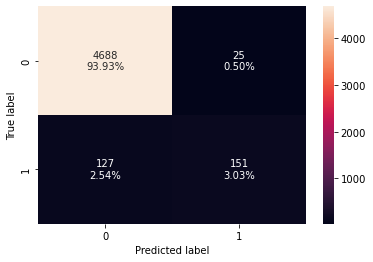

In [152]:
#creating confusion matrix
confusion_matrix_sklearn(dtree_original_tuned, X_val, y_val)

Observation: 

Overall score: 
- TERRIBLE - 0.57

Training vs Validation: 
- Accuracy and precision strong on validation data
- recall worst we've seen yet - .54

### Tuning decision tree model with oversampled data

In [153]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_depth': np.arange(2,6), 
              'min_samples_leaf': [1, 4, 7], 
              'max_leaf_nodes' : [10, 15], 
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9210100179840739:


In [154]:
#building model using best parameters 
dtree_over_tuned = DecisionTreeClassifier(
    min_samples_leaf=7,
    min_impurity_decrease=0.001,
    max_leaf_nodes=15,
    max_depth=3,
    random_state=1)

#fit the model on training data
dtree_over_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       random_state=1)

In [155]:
#calculating metrics on train and validation set 
dtree_over_tuned_train = model_performance_classification_sklearn(dtree_over_tuned, X_train, y_train)
dtree_over_tuned_perf = model_performance_classification_sklearn(dtree_over_tuned, X_val, y_val)

print("Training performance:")
dtree_over_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.471,0.877,0.613


In [156]:
print("Validation performance:")
dtree_over_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.965,0.471,0.819,0.598


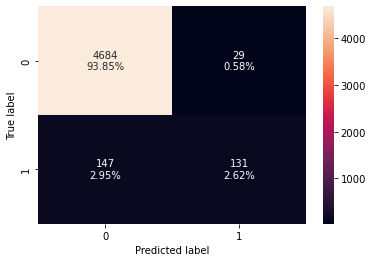

In [157]:
#creating confusion matrix
confusion_matrix_sklearn(dtree_over_tuned, X_val, y_val)

Observation: 

Overall score: 
- much better, 0.92 

Training vs Validation: 
- accuracy and precision are similar to tuned decision tree with original data
- recall has fallen even further 

### Tuning decision tree model with undersampled data

In [158]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_depth': np.arange(2,6), 
              'min_samples_leaf': [1, 4, 7], 
              'max_leaf_nodes' : [10, 15], 
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.8582425510424934:


In [159]:
#building model using best parameters 
dtree_under_tuned = DecisionTreeClassifier(
    min_samples_leaf=7,
    min_impurity_decrease=0.001,
    max_leaf_nodes=15,
    max_depth=3,
    random_state=1)

#fit the model on training data
dtree_under_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       random_state=1)

In [160]:
#calculating metrics on train and validation set 
dtree_under_tuned_train = model_performance_classification_sklearn(dtree_under_tuned, X_train, y_train)
dtree_under_tuned_perf = model_performance_classification_sklearn(dtree_under_tuned, X_val, y_val)

print("Training performance:")
dtree_under_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.471,0.877,0.613


In [161]:
print("Validation performance:")
dtree_under_tuned_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.965,0.471,0.819,0.598


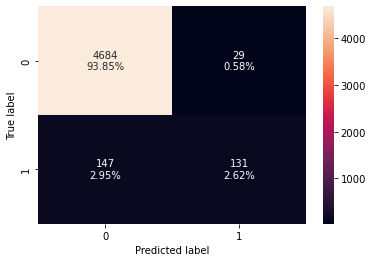

In [162]:
#creating confusion matrix
confusion_matrix_sklearn(dtree_under_tuned, X_val, y_val)

Observation: 

Overall score: 
- strong score 0.85, but not the strongest we've seen 

Training vs Validation: 
- recall is atrocious 
- accuracy and precision strong, but we need that recall 

## Model performance comparison and choosing the final model

In [171]:
#printing recall metrics for quick reference: 
print(bagging_original_tuned_perf['Recall'],
bagging_over_tuned_perf['Recall'],
bagging_under_tuned_perf['Recall'],
rf_original_tuned_perf['Recall'],
rf_over_tuned_perf['Recall'],
rf_under_tuned_perf['Recall'],
gbm_original_tuned_perf['Recall'],
gbm_over_tuned_perf['Recall'],
gbm_under_tuned_perf['Recall'],
ada_original_tuned_perf['Recall'],
ada_over_tuned_perf['Recall'],
ada_under_tuned_perf['Recall'],
xgb_original_tuned_perf['Recall'],
xgb_over_tuned_perf['Recall'],
xgb_under_tuned_perf['Recall'],
dtree_original_tuned_perf['Recall'],
dtree_over_tuned_perf['Recall'],
dtree_under_tuned_perf['Recall'])

0   0.748
Name: Recall, dtype: float64 0   0.748
Name: Recall, dtype: float64 0   0.748
Name: Recall, dtype: float64 0   0.727
Name: Recall, dtype: float64 0   0.730
Name: Recall, dtype: float64 0   0.730
Name: Recall, dtype: float64 0   0.784
Name: Recall, dtype: float64 0   0.619
Name: Recall, dtype: float64 0   0.784
Name: Recall, dtype: float64 0   0.759
Name: Recall, dtype: float64 0   0.759
Name: Recall, dtype: float64 0   0.759
Name: Recall, dtype: float64 0   0.849
Name: Recall, dtype: float64 0   0.867
Name: Recall, dtype: float64 0   0.867
Name: Recall, dtype: float64 0   0.543
Name: Recall, dtype: float64 0   0.471
Name: Recall, dtype: float64 0   0.471
Name: Recall, dtype: float64


original data 

- Bagging: 0.6942446043165468
- Random forest: 0.7446043165467626
- GBM: 0.7482014388489209
- Adaboost: 0.6330935251798561
- Xgboost: 0.8201438848920863
- dtree: 0.7086330935251799

Over-sampled data

- Bagging: 0.8489208633093526
- Random forest: 0.841726618705036
- GBM: 0.8741007194244604
- Adaboost: 0.8525179856115108
- Xgboost: 0.8597122302158273
- dtree: 0.7985611510791367

Under-sampled data 

- Bagging: 0.8741007194244604
- Random forest: 0.8848920863309353
- GBM: 0.8920863309352518
- Adaboost: 0.8525179856115108
- Xgboost: 0.8920863309352518
- dtree: 0.8453237410071942

Tuned data 

- bagging_original_tuned_perf: 0.748
- bagging_over_tuned_perf: 0.748
- bagging_under_tuned_perf: 0.748
- rf_original_tuned_perf: 0.727
- rf_over_tuned_perf: 0.730
- rf_under_tuned_perf: 0.730
- gbm_original_tuned_perf: 0.784
- gbm_over_tuned_perf: 0.619
- gbm_under_tuned_perf: 0.784
- ada_original_tuned_perf: 0.759
- ada_over_tuned_perf: 0.759
- ada_under_tuned_perf: 0.759
- xgb_original_tuned_perf: 0.849
- xgb_over_tuned_perf: 0.867
- xgb_under_tuned_perf: 0.867
- dtree_original_tuned_perf: 0.543
- dtree_over_tuned_perf: 0.471
- dtree_under_tuned_perf: 0.471

In [173]:
#name model
gbm_under = GradientBoostingClassifier(random_state=1)

#fit the model on training data
gbm_under.fit(X_train_un, y_train_un)

GradientBoostingClassifier(random_state=1)

In [174]:
#calculating metrics on train and validation set 
gbm_under_train = model_performance_classification_sklearn(gbm_under, X_train, y_train)
gbm_under_perf = model_performance_classification_sklearn(gbm_under, X_val, y_val)

print("Training performance:")
gbm_under_train 

Training performance:


,Accuracy,Recall,Precision,F1
0,0.948,0.945,0.518,0.669


In [175]:
print("Validation performance:")
gbm_under_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.947,0.892,0.515,0.653


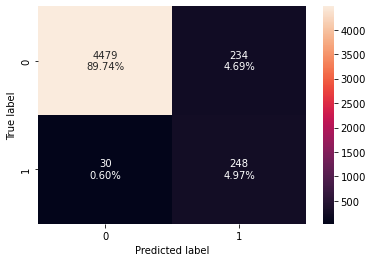

In [177]:
#creating confusion matrix
confusion_matrix_sklearn(gbm_under, X_val, y_val)

Reviewing recall across all models, the following 2 models performed the best using under-sampled data: 
GBM: 0.8920863309352518
Xgboost: 0.8920863309352518

Gradient boost had the lowest cost at 0.9038, so I will choose that as the final model. 

It does have quite low precision, but the cost of repairing is so much more expensive than the cost of replacing, and the cost of testing is the lowest, that this will result inthe lowest cost. 

### Test set final performance

In [178]:
#calculating metrics on test set 
gbm_under_test = model_performance_classification_sklearn(gbm_under, X_test, y_test)

print("Training performance:")
gbm_under_test 

Training performance:


,Accuracy,Recall,Precision,F1
0,0.943,0.865,0.497,0.631


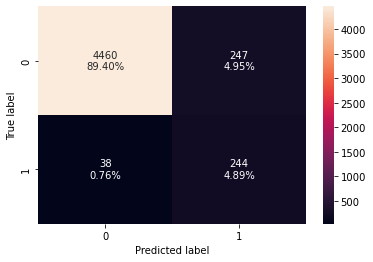

In [179]:
#creating confusion matrix
confusion_matrix_sklearn(gbm_under, X_test, y_test)

Results are similar on test set as they were on the train and validation
- performance has generalized
- high accuracy and recall 
- lower precision, but again, this is prioritizing the cost of testing over the cost of replacement 

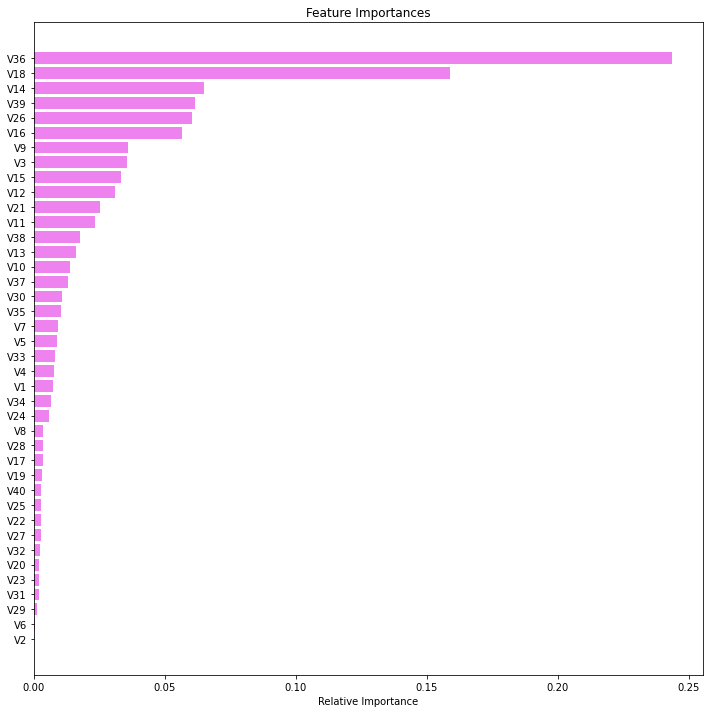

In [181]:
feature_names = X_test.columns
importances = gbm_under.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

The most important variables: 
- V36at .25 (extremely important) 
- V18 second at .18 
- followed closely by V14, 39, 26, and 16 with similar importance of .08 

## Pipelines to build the final model


In [184]:
#separating target variable 
X_train = train.drop(columns='Target')
y_train = train['Target']

X_test = test.drop(columns='Target')
y_test = test['Target']

In [185]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [186]:
#creating a pipeline with our best pipeline 
model = Pipeline(
    steps=[
        ("imputer",
             SimpleImputer(strategy="median")
        ),
        ("GBM",
            GradientBoostingClassifier(random_state=1),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train_un, y_train_un)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('GBM', GradientBoostingClassifier(random_state=1))])

In [187]:
#calculating metrics on test set 
model_test = model_performance_classification_sklearn(model, X_test, y_test)

print("Training performance:")
model_test 

Training performance:


,Accuracy,Recall,Precision,F1
0,0.936,0.858,0.464,0.602


# Business Insights and Conclusions

- Company should focus on the following variables for possible indications of failiure:: 
    - V36 has the strongest importance by far (.25)
    - V18 has the second most important influence 
        - Particularly if V18 values drop below -5 
    - V14, V16 (particularly above 5), V26 (particularly lower levels), and V39 (particulary below -3) have the next highest importance at about the same strength
    
    
- failures are relatively rare, but the cost of replacing turbines that were not caught before full failure is high enough that this model prioritizes running more tests 
    - companies could begin automated checks for the primary variables to flag turbines that are reaching concerning levels 
    - some of the variables didn't have significant extreme ranges to flag but are still strong indicators (such as V36) 
    - the pipeline should be used to re-run new data regularly 

- For the most influential variables, the company could implement additional analyses noting if things such as environmental influence could increase those values 
    - ex: heat waves might increase the overall temperature of the wind turbines, which could be one of the indicators for failure 
    - unfortunately since the variables are ciphered, it is difficult to provide specific recommendations 
    
        
*Thank you for the opportunity to work with your company and provide insight! Thank you for your work in this incredibly important field, and for aiming to increase reliability and excellence.*